In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn.preprocessing import LabelEncoder, StandardScaler


from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import plot_confusion_matrix, auc, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings("ignore")

In [3]:
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from optuna.samplers import GridSampler, RandomSampler

In [4]:
# функция преобразования данных
def EDA(df, df1, num_cols, bin_cols, cat_cols):
    
    n_cols = num_cols.copy()
    b_cols = bin_cols.copy()
    c_cols = cat_cols.copy()
    
    n_cols1 = num_cols.copy()
    b_cols1 = bin_cols.copy()
    c_cols1 = cat_cols.copy()
    
    #train
    
    # заменим пропуски пропорционально имеющимся данным
    edu_list = df.education.value_counts()
    edu = [edu_list.index[x] for x in range(5)]
    p = [edu_list[z]/edu_list.sum() for z in range(5)]

    a = np.random.choice(edu, df.education.isna().sum(), p=p)
    count = 0
    for i in range(len(df.education)):
        if pd.isna(df.loc[i, 'education']) :
            df.loc[i, 'education'] = a[count]
            count += 1
    
   
    # преобразуем колонку с датой
    df['app_date'] = pd.to_datetime(df.app_date)
    df['weekday'] = df['app_date'].apply(lambda x: x.weekday())
    df['app_date'] = df['app_date'].apply(lambda x: (x - df['app_date'].min()).days)
    n_cols.append('app_date')
    c_cols.append('weekday')
    
    # преобразуем бинарные признаки    
    label_encoder_sex = LabelEncoder()
    label_encoder_car = LabelEncoder()
    label_encoder_car_type = LabelEncoder()
    label_encoder_good_work = LabelEncoder()
    label_encoder_foreign_passport = LabelEncoder()
    
    df["sex"] = label_encoder_sex.fit_transform(df["sex"])
    df["car"] = label_encoder_car.fit_transform(df["car"])
    df["car_type"] = label_encoder_car_type.fit_transform(df["car_type"])
    df["good_work"] = label_encoder_good_work.fit_transform(df["good_work"])
    df["foreign_passport"] = label_encoder_foreign_passport.fit_transform(df["foreign_passport"])
    
    
    # создание новых признаков
    df.score_bki = np.abs(df.score_bki)
    df.age = np.log(df.age)
    df.income = np.log(df.income)
    df.bki_request_cnt = np.log(df.bki_request_cnt+1)
        
    decline_age = df.groupby('decline_app_cnt')['age'].mean().to_dict()
    df['decline_age'] = df['decline_app_cnt'].map(decline_age)
    n_cols.append('decline_age')

    decline_bki = df.groupby('decline_app_cnt')['score_bki'].mean().to_dict()
    df['decline_bki'] = df['decline_app_cnt'].map(decline_bki)
    n_cols.append('decline_bki')

    decline_region = df.groupby('decline_app_cnt')['region_rating'].mean().to_dict()
    df['decline_region'] = df['decline_app_cnt'].map(decline_region)
    n_cols.append('decline_region')

    decline_request = df.groupby('decline_app_cnt')['bki_request_cnt'].mean().to_dict()
    df['decline_request'] = df['decline_app_cnt'].map(decline_request)
    n_cols.append('decline_request')

    region_age = df.groupby('region_rating')['age'].mean().to_dict()
    df['region_age'] = df['region_rating'].map(region_age)
    n_cols.append('region_age')

    region_income = df.groupby('region_rating')['income'].mean().to_dict()
    df['region_income'] = df['region_rating'].map(region_income)
    n_cols.append('region_income')
    
    
    # стандартизация числовых переменных
    scaler = StandardScaler()
    df[n_cols] = scaler.fit_transform(df[n_cols])
    
    
    # преобразование категориальных переменных
    df = pd.get_dummies(df, columns = c_cols)
    
    X = df.drop(['client_id', 'default'], axis=1).values
    y = df['default'].values 
    
    
    #проделаем тоже самое для тестового набора данных
    
    #test
    
    # заменим пропуски пропорционально имеющимся данным
    edu_list = df1.education.value_counts()
    edu = [edu_list.index[x] for x in range(5)]
    p = [edu_list[z]/edu_list.sum() for z in range(5)]

    a = np.random.choice(edu, df1.education.isna().sum(), p=p)
    count = 0
    for i in range(len(df1.education)):
        if pd.isna(df1.loc[i, 'education']) :
            df1.loc[i, 'education'] = a[count]
            count += 1
    
    
    df1['app_date'] = pd.to_datetime(df1.app_date)
    df1['weekday'] = df1['app_date'].apply(lambda x: x.weekday())
    df1['app_date'] = df1['app_date'].apply(lambda x: (x - df1['app_date'].min()).days)
    n_cols1.append('app_date')
    c_cols1.append('weekday')
    
    
    
    df1["sex"] = label_encoder_sex.transform(df1["sex"])
    df1["car"] = label_encoder_car.transform(df1["car"])
    df1["car_type"] = label_encoder_car_type.transform(df1["car_type"])
    df1["good_work"] = label_encoder_good_work.transform(df1["good_work"])
    df1["foreign_passport"] = label_encoder_foreign_passport.transform(df1["foreign_passport"])
        
    
    
    
    df1.score_bki = np.abs(df1.score_bki)
    df1.age = np.log(df1.age)
    df1.income = np.log(df1.income)
    df1.bki_request_cnt = np.log(df1.bki_request_cnt+1)
        
    decline_age1 = df1.groupby('decline_app_cnt')['age'].mean().to_dict()
    df1['decline_age'] = df1['decline_app_cnt'].map(decline_age1)
    n_cols1.append('decline_age')

    decline_bki1 = df1.groupby('decline_app_cnt')['score_bki'].mean().to_dict()
    df1['decline_bki'] = df1['decline_app_cnt'].map(decline_bki1)
    n_cols1.append('decline_bki')

    decline_region1 = df1.groupby('decline_app_cnt')['region_rating'].mean().to_dict()
    df1['decline_region'] = df1['decline_app_cnt'].map(decline_region1)
    n_cols1.append('decline_region')

    decline_request1 = df1.groupby('decline_app_cnt')['bki_request_cnt'].mean().to_dict()
    df1['decline_request'] = df1['decline_app_cnt'].map(decline_request1)
    n_cols1.append('decline_request')

    region_age1 = df1.groupby('region_rating')['age'].mean().to_dict()
    df1['region_age'] = df1['region_rating'].map(region_age1)
    n_cols1.append('region_age')

    region_income1 = df1.groupby('region_rating')['income'].mean().to_dict()
    df1['region_income'] = df1['region_rating'].map(region_income1)
    n_cols1.append('region_income')
    
    df1[n_cols1] = scaler.transform(df1[n_cols1])
    
    df1 = pd.get_dummies(df1, columns = c_cols1)
    
    X1 = df1.drop('client_id', axis=1).values
    
    
    
    return X, X1, y

In [5]:
# функция подсчета выбросов
def q(s):
    IQR = s.quantile(0.75) - s.quantile(0.25)
    perc25 = s.quantile(0.25)
    perc75 = s.quantile(0.75)
    f = perc25 - 1.5*IQR
    l = perc75 + 1.5*IQR
    print(
        '25-й перцентиль: {},'.format(perc25),
        '75-й перцентиль: {},'.format(perc75),
        "IQR: {}, ".format(IQR),
        "Границы выбросов: [{}, {}].".format(f, l))
    return perc25, perc75, f, l

In [6]:
# функция расчета метрик
def score(model, X_test, y_test):
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    
    
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plot_confusion_matrix(model, X_test, y_test)
    plt.show()

In [7]:
# загружаем данные
train = pd.read_csv('../input/sf-dst-scoring/train.csv')
test = pd.read_csv('../input/sf-dst-scoring/test.csv')

In [8]:
# первый взгляд на тренировочные данные
train

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,0
73795,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,0
73796,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,0
73797,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1


In [9]:
# изучаем тренировочные данные
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

18 колонок и 79799 строк в данных, в колонке education есть пропуски, шесть переменных нечисловые

In [10]:
# изучаем тренировочные данные
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

в тестовых данных аналогичная ситуация

In [11]:
# посчитаем количество пропусков
train.isnull().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

колонка education имеет 307 пустых значений

In [12]:
# посчитаем количество уникальных элементов в переменных
train.nunique()

client_id           73799
app_date              120
education               5
sex                     2
age                    52
car                     2
car_type                2
decline_app_cnt        21
good_work               2
score_bki           69096
bki_request_cnt        38
region_rating           7
home_address            3
work_address            3
income                966
sna                     4
first_time              4
foreign_passport        2
default                 2
dtype: int64

определяем числовые, бинарные и категориальные признаки

In [13]:
# числовые признаки
num_cols = ["age", "decline_app_cnt", "score_bki",
            "bki_request_cnt", "income", "region_rating"]

# бинарные признаки
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"]

# категориальные признаки
cat_cols = ["education", "home_address", "work_address", "sna", "first_time"]

# default

<AxesSubplot:xlabel='default', ylabel='count'>

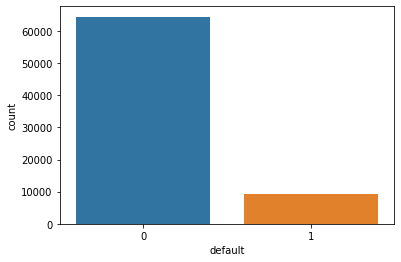

In [14]:
# посмотрим на распределение целевой переменной
sns.countplot(train.default)

In [15]:
train.default.value_counts()

0    64427
1     9372
Name: default, dtype: int64

In [16]:
64427/9372

6.874413145539906

имеется перекос в классах, количество отказов почти в семь раз больше положительных решений,

будем использовать дублирование отказов в датасете и использовать стратификацию в разбивке датасета при обучении

In [17]:
num_cols1 = num_cols.copy()
num_cols1.append('default')

<AxesSubplot:>

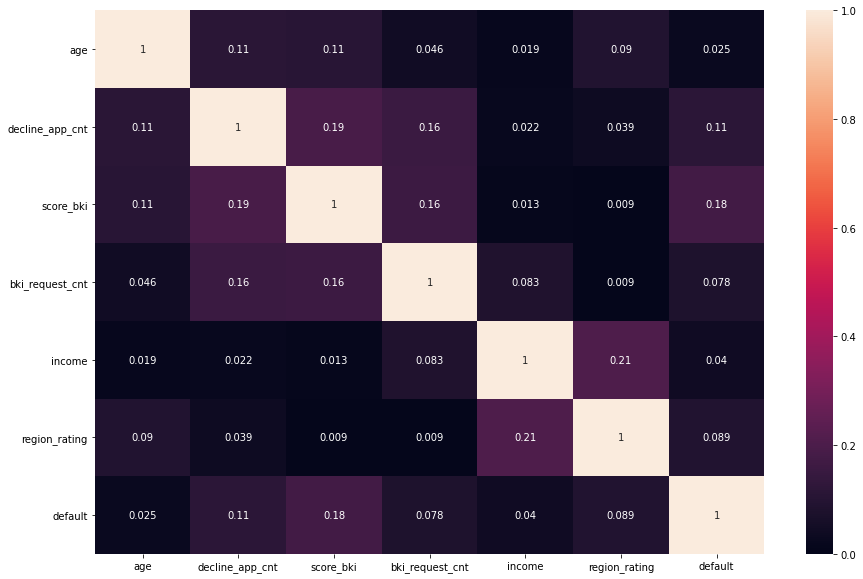

In [18]:
plt.figure(figsize=(15,10))
sns.heatmap(train[num_cols1].corr().abs(), vmin=0, vmax=1, annot=True)

все признаки слабо скоррелированы

In [19]:
# преобразуем колонку с датой
train['app_date'] = pd.to_datetime(train.app_date)
train['weekday'] = train['app_date'].apply(lambda x: x.weekday())
train['app_date'] = train['app_date'].apply(lambda x: (x - train['app_date'].min()).days) # days from the first date
num_cols.append('app_date')
cat_cols.append('weekday')

In [20]:
# заменим пропуски в колонке education пропорционально имеющимся данным
edu_list = train.education.value_counts()
edu = [edu_list.index[x] for x in range(5)]
p = [edu_list[z]/edu_list.sum() for z in range(5)]
print(edu, p)
a = np.random.choice(edu, train.education.isna().sum(), p=p)
count = 0
for i in range(len(train.education)):
    if pd.isna(train.loc[i, 'education']) :
        train.loc[i, 'education'] = a[count]
        count += 1
        
# преобразуем в числовые данные
edu_index = edu_list.index
train.education = train.education.apply(lambda x: 0 if x == edu_index[0] else 1 if x == edu_index[1] else 2 if x == edu_index[2]
                                 else 3 if x == edu_index[3] else 4)

['SCH', 'GRD', 'UGR', 'PGR', 'ACD'] [0.5287650356501388, 0.317925760627007, 0.13356555815598978, 0.017103902465574486, 0.0026397431012899365]


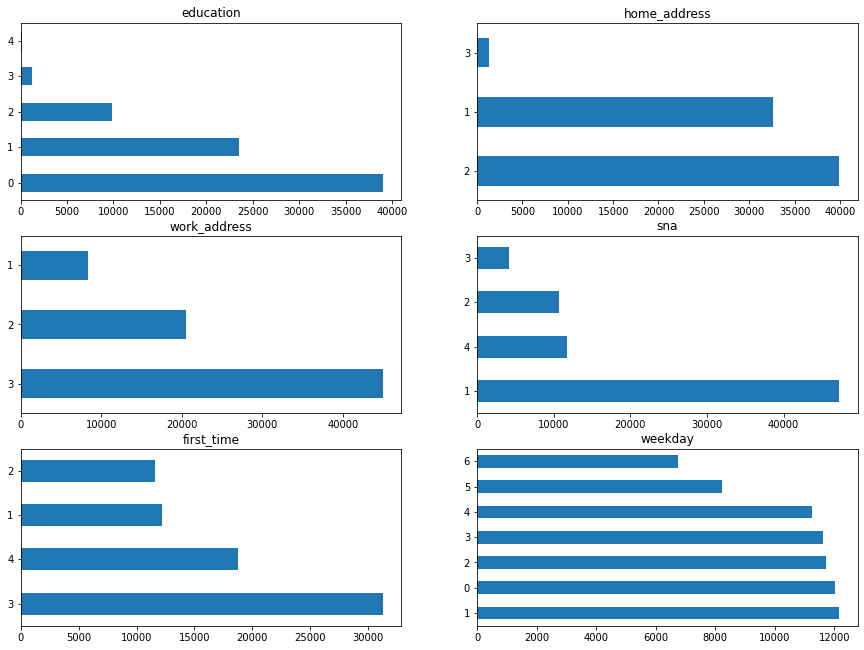

In [21]:
# сейчас можно посмотреть на категориальные признаки поближе
plt.figure(figsize=(15,15))
a = 1
for i in cat_cols:
    plt.subplot(len(cat_cols)/2+1, 2, a)
    train[i].value_counts().plot.barh()
    plt.title(i)
    a+=1

все признаки достаточно равномерно распределены

In [22]:
# Для бинарных признаков мы будем использовать LabelEncoder


label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    
# убедимся в преобразовании    
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,weekday
0,25905,31,0,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0,5
1,63161,70,0,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0,2
2,25887,31,0,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0,5
3,16222,22,0,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0,3
4,101655,107,1,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0,4


<AxesSubplot:>

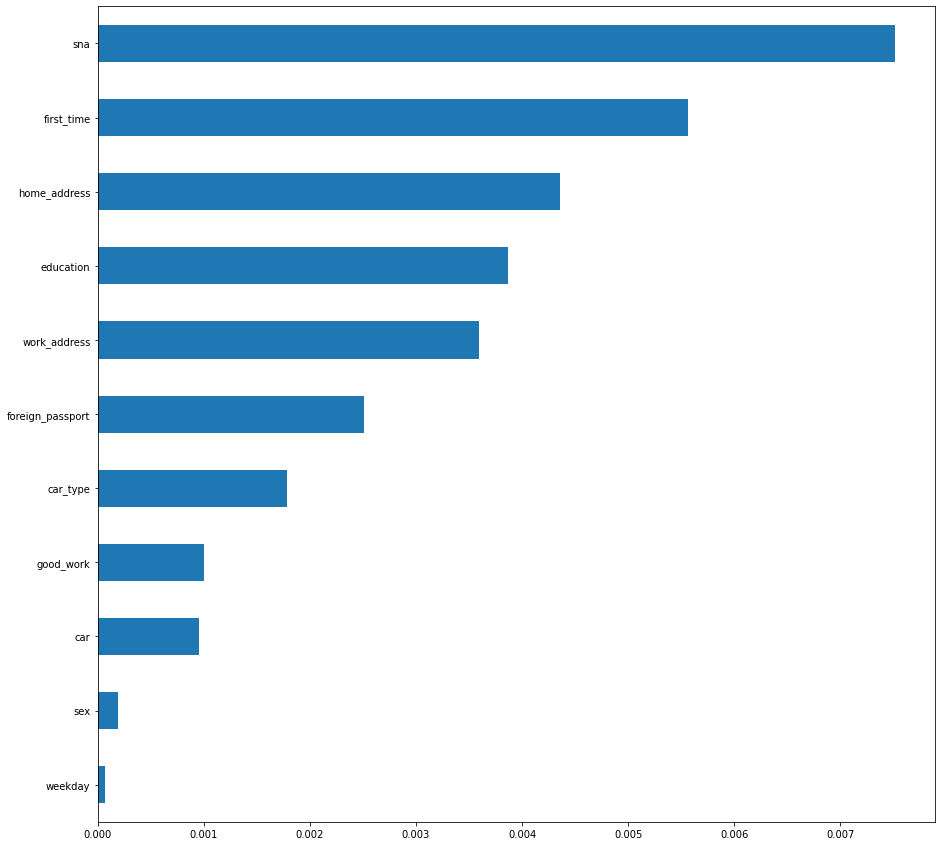

In [23]:
# оценим значимость категориальных и бинарных признаков
plt.figure(figsize=(15,15))
imp_cat = pd.Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

# числовые признаки

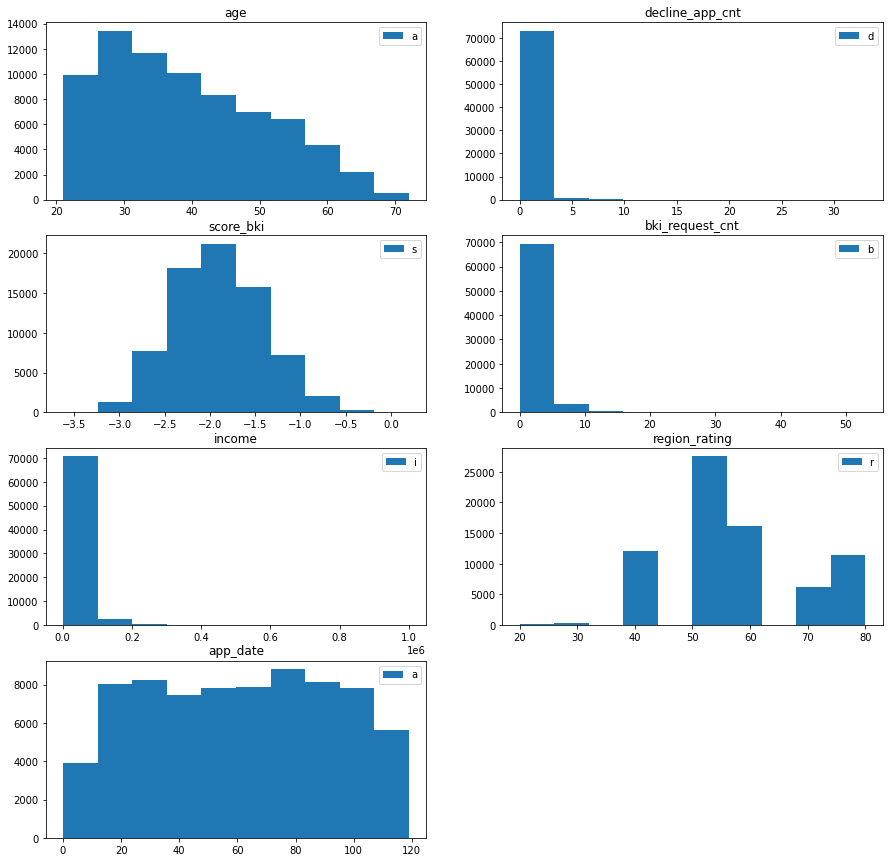

In [24]:
# посмотрим на распределение числовых переменных
a = 1
plt.figure(figsize=(15, 15))
for i in num_cols:
    plt.subplot(len(num_cols)/2+1, 2, a)
    plt.hist(train[i])
    plt.title(i)
    plt.legend(i)
    a+=1

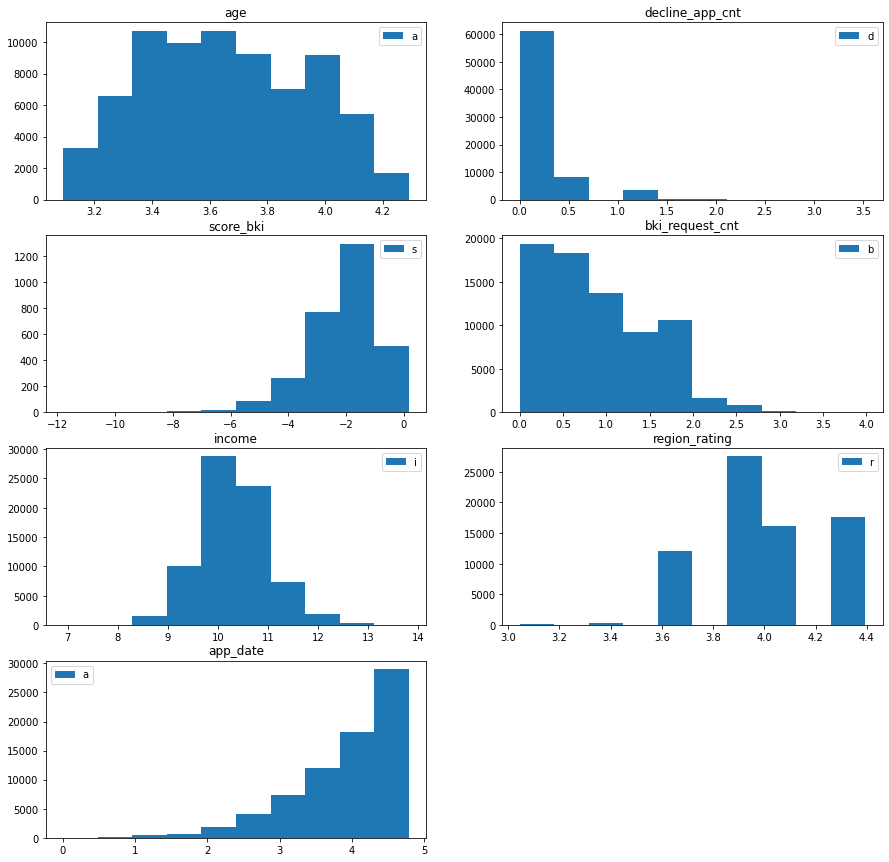

In [25]:
# и как они будут выглядеть после логарифмирования
a = 1
plt.figure(figsize=(15, 15))
for i in num_cols:
    plt.subplot(len(num_cols)/2+1, 2, a)
    plt.hist(np.log(train[i]+1))
    plt.title(i)
    plt.legend(i)
    a+=1

In [26]:
# оценим выбросы в данных
for i in num_cols:
    print(i)
    q(train[i])
    print(train[i].min(),train[i].max())
    print()

age
25-й перцентиль: 30.0, 75-й перцентиль: 48.0, IQR: 18.0,  Границы выбросов: [3.0, 75.0].
21 72

decline_app_cnt
25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].
0 33

score_bki
25-й перцентиль: -2.259533835, 75-й перцентиль: -1.56983126, IQR: 0.6897025750000001,  Границы выбросов: [-3.2940876975, -0.5352773974999998].
-3.62458632 0.19977285

bki_request_cnt
25-й перцентиль: 0.0, 75-й перцентиль: 3.0, IQR: 3.0,  Границы выбросов: [-4.5, 7.5].
0 53

income
25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].
1000 1000000

region_rating
25-й перцентиль: 50.0, 75-й перцентиль: 60.0, IQR: 10.0,  Границы выбросов: [35.0, 75.0].
20 80

app_date
25-й перцентиль: 33.0, 75-й перцентиль: 89.0, IQR: 56.0,  Границы выбросов: [-51.0, 173.0].
0 119



In [27]:
train.score_bki[train.score_bki > -0.5352773974999998]

56      -0.500103
80      -0.266137
235     -0.275273
429     -0.523215
446     -0.523830
           ...   
72968   -0.156601
72993   -0.012303
73265   -0.470095
73367   -0.281990
73644   -0.459329
Name: score_bki, Length: 299, dtype: float64

In [28]:
train.score_bki[train.score_bki > 0]

706      0.168549
2527     0.198070
4383     0.023908
14969    0.056035
33790    0.021617
45078    0.199773
50938    0.199773
58642    0.045959
58789    0.183613
Name: score_bki, dtype: float64

In [30]:
# преобразуем колонку score_bki
train.score_bki = np.abs(train.score_bki)

In [31]:
train.decline_app_cnt[train.decline_app_cnt > 0]

2        2
8        1
10       2
33       2
38       1
        ..
73757    2
73762    1
73771    3
73776    4
73782    2
Name: decline_app_cnt, Length: 12585, dtype: int64

In [32]:
train.decline_app_cnt[train.decline_app_cnt > 0].value_counts()

1     8397
2     2468
3      903
4      414
5      165
6      113
7       48
9       24
8       19
10      11
11       9
13       3
12       2
14       2
16       2
19       1
33       1
22       1
24       1
15       1
Name: decline_app_cnt, dtype: int64

In [33]:
train.default[train.decline_app_cnt > 10].value_counts()

0    16
1     7
Name: default, dtype: int64

In [34]:
train.default[train.decline_app_cnt == 1].value_counts()

0    6820
1    1577
Name: default, dtype: int64

In [35]:
train.bki_request_cnt[train.bki_request_cnt > 7.5]

54        8
107      13
114       8
185      13
188      10
         ..
73334    11
73412    28
73461    23
73679     8
73771    12
Name: bki_request_cnt, Length: 1755, dtype: int64

In [36]:
train.bki_request_cnt[train.bki_request_cnt > 7.5].value_counts()

8     508
9     299
10    225
11    188
12    144
13     94
14     86
15     54
16     35
18     22
17     19
19     18
21     12
24     11
20      9
23      7
22      4
28      4
25      2
26      2
27      2
32      2
46      1
29      1
33      1
34      1
36      1
41      1
45      1
53      1
Name: bki_request_cnt, dtype: int64

In [37]:
train.default[train.bki_request_cnt > 7.5].value_counts()

0    1371
1     384
Name: default, dtype: int64

In [38]:
train.income[train.income > 90000]

28       100000
54       200000
67       130000
72       350000
76       100000
          ...  
73731    200000
73739    120000
73740    200000
73749    120000
73790    100600
Name: income, Length: 4695, dtype: int64

In [39]:
train.income[train.income > 90000].value_counts()

100000    1381
150000     680
120000     531
200000     341
300000     169
          ... 
275000       1
144000       1
947000       1
95100        1
213000       1
Name: income, Length: 184, dtype: int64

In [40]:
train.default[train.income > 90000].value_counts()

0    4295
1     400
Name: default, dtype: int64

в данных имеются выбросы, но их невозможно интерпретировать, явных зависимостей нет

In [41]:
# прологарифмируем некоторые переменные
train.age = np.log(train.age)
train.income = np.log(train.income)
train.bki_request_cnt = np.log(train.bki_request_cnt+1)

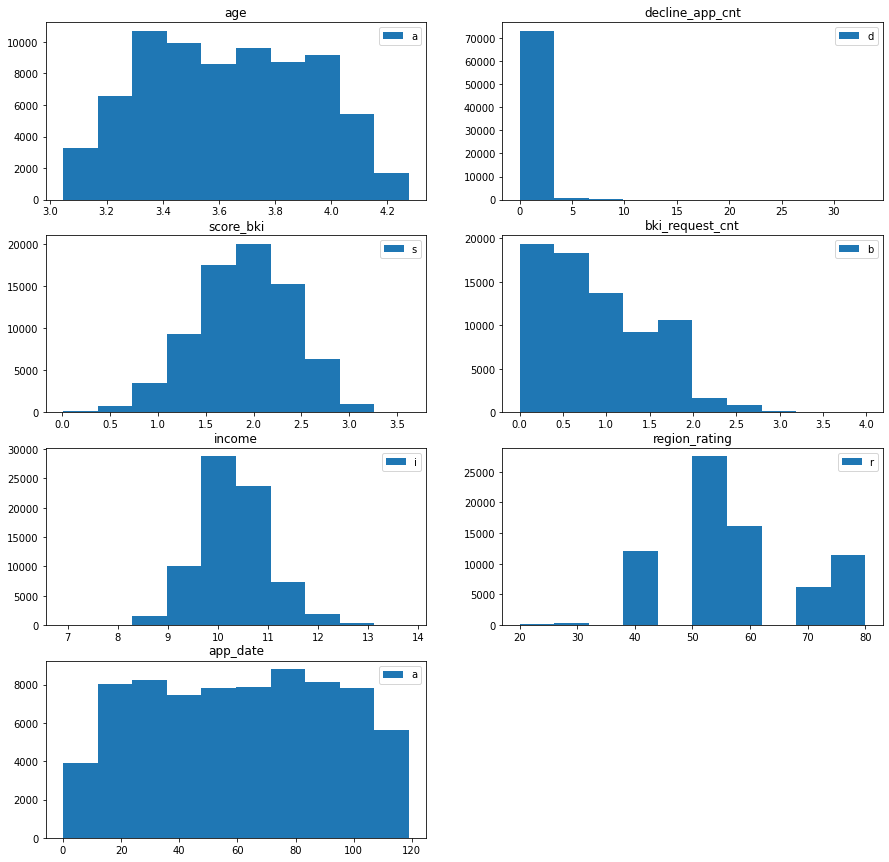

In [42]:
a = 1
plt.figure(figsize=(15, 15))
for i in num_cols:
    plt.subplot(len(num_cols)/2+1, 2, a)
    plt.hist(train[i])
    plt.title(i)
    plt.legend(i)
    a+=1

In [43]:
# сгенерируем новые признаки
col = num_cols.copy()
num_cols_feat = []
for i in col:
    for j in col:
        if i != j:
            a = train.groupby(i)[j].mean().to_dict()
            train[str(i)+'_'+str(j)] = train[i].map(a)
            num_cols_feat.append(str(i)+'_'+str(j))

<AxesSubplot:>

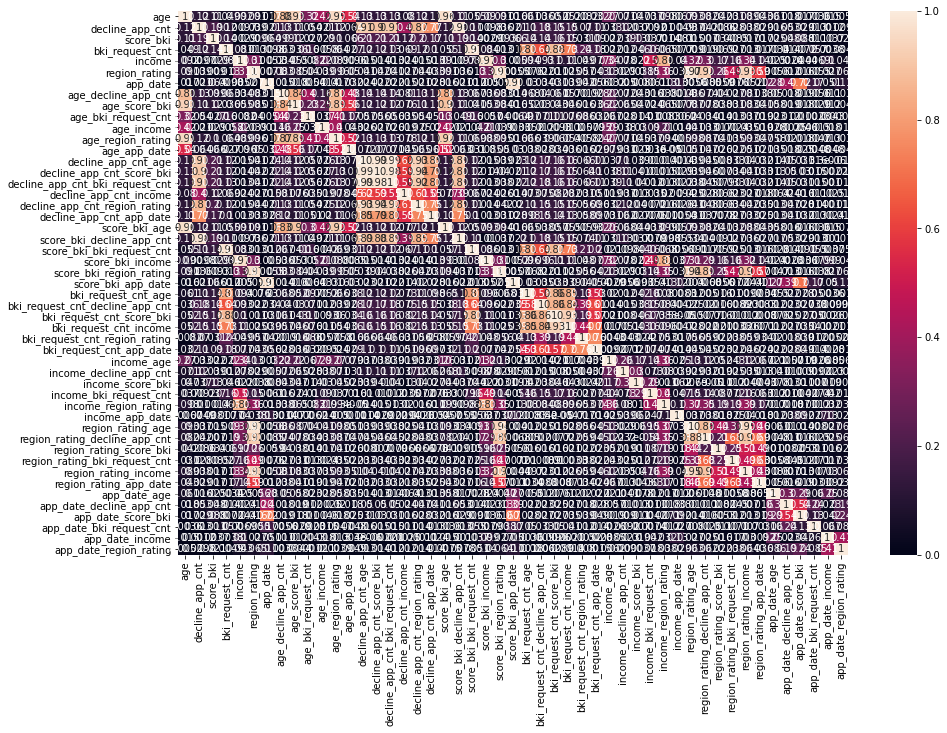

In [44]:
plt.figure(figsize=(15,10))
sns.heatmap(train[num_cols+num_cols_feat].corr().abs(), vmin=0, vmax=1, annot=True)

<AxesSubplot:>

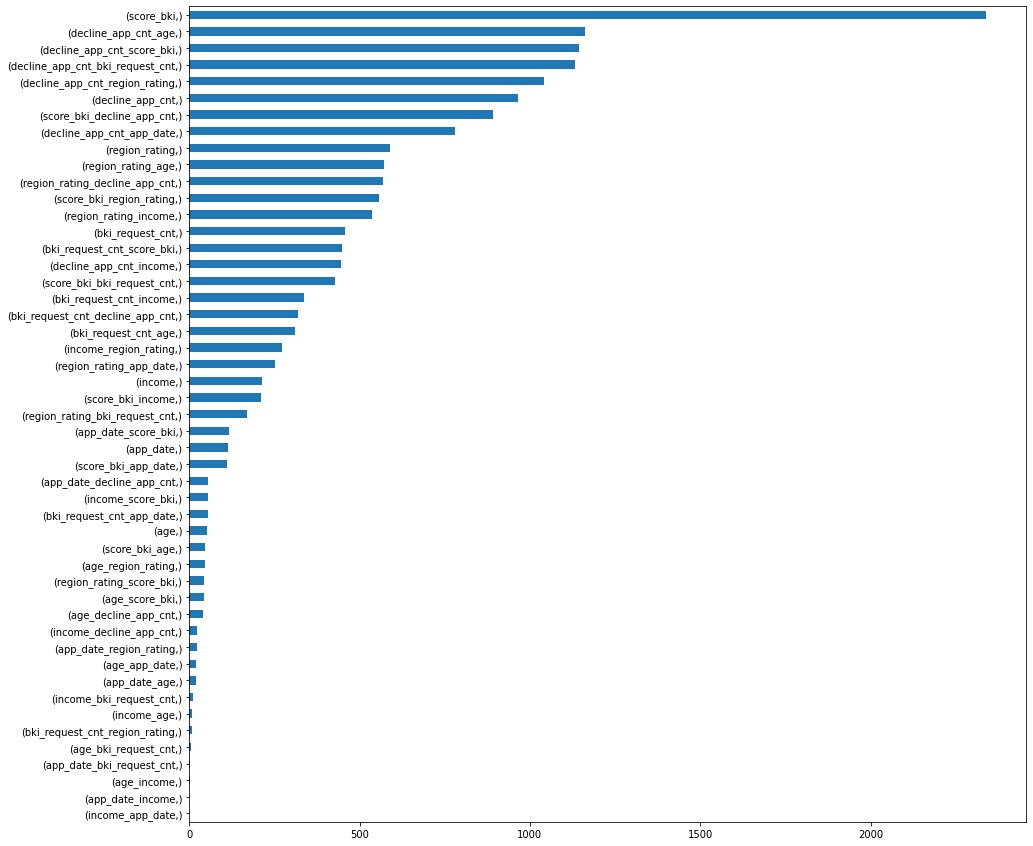

In [45]:
# оценим вклад каждого из них
imp_num = pd.Series(f_classif(train[num_cols+num_cols_feat], train['default'])[0], 
                    index = [num_cols+num_cols_feat])
imp_num.sort_values(inplace = True)
plt.figure(figsize=(15, 15))
imp_num.plot(kind = 'barh')

In [46]:
# возьмем наиболее значимые
decline_age = train.groupby('decline_app_cnt')['age'].mean().to_dict()
train['decline_age'] = train['decline_app_cnt'].map(decline_age)
num_cols.append('decline_age')

decline_bki = train.groupby('decline_app_cnt')['score_bki'].mean().to_dict()
train['decline_bki'] = train['decline_app_cnt'].map(decline_bki)
num_cols.append('decline_bki')

decline_region = train.groupby('decline_app_cnt')['region_rating'].mean().to_dict()
train['decline_region'] = train['decline_app_cnt'].map(decline_region)
num_cols.append('decline_region')

decline_request = train.groupby('decline_app_cnt')['bki_request_cnt'].mean().to_dict()
train['decline_request'] = train['decline_app_cnt'].map(decline_request)
num_cols.append('decline_request')

region_age = train.groupby('region_rating')['age'].mean().to_dict()
train['region_age'] = train['region_rating'].map(region_age)
num_cols.append('region_age')

region_income = train.groupby('region_rating')['income'].mean().to_dict()
train['region_income'] = train['region_rating'].map(region_income)
num_cols.append('region_income')

<AxesSubplot:>

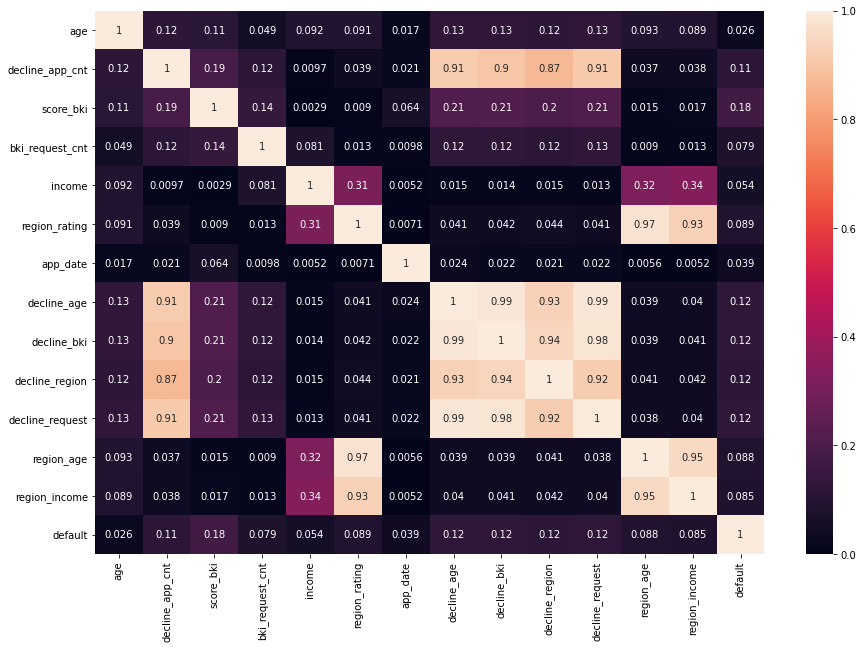

In [47]:
plt.figure(figsize=(15,10))
sns.heatmap(train[num_cols+['default']].corr().abs(), vmin=0, vmax=1, annot=True)

In [48]:
# стандартизируем числовые признаки
train[num_cols] = StandardScaler().fit_transform(train[num_cols].values)

In [49]:
train = pd.get_dummies(train, columns = cat_cols)

In [51]:
X = train.drop(['client_id', 'default'], axis=1).values
y = train['default'].values 

все наши преобразования данных перенесем в функцию EDA

# Обучаем модели

In [52]:
# загружаем данные
train = pd.read_csv('../input/sf-dst-scoring/train.csv')
test = pd.read_csv('../input/sf-dst-scoring/test.csv')

In [53]:
# числовые признаки
num_cols = ["age", "decline_app_cnt", "score_bki",
            "bki_request_cnt", "income", "region_rating"]

# бинарные признаки
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"]

# категориальные признаки
cat_cols = ["education", "home_address", "work_address", "sna", "first_time"]

In [54]:

X, X1, y = EDA(train, test, num_cols, bin_cols, cat_cols)


In [55]:
print(X.shape)
print(X1.shape)
print(y.shape)

(73799, 44)
(36349, 44)
(73799,)


In [56]:
# стратифицировано разобъем наши данные для обучения
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [57]:
# проверим разбивку
print(len(y_train)/len(y_train[y_train==1]))
print(len(y_test)/len(y_test[y_test==1]))

7.87396639103761
7.876200640341516


## Optuna

Логистическая регрессия

In [58]:
def objective(trial, data=X, target=y):
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in sss.split(data, target):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
    C = trial.suggest_loguniform('C', 10, 1000)
    max_iter = trial.suggest_int('max_iter', 100,1000)
    penalty = trial.suggest_categorical('penalty', ['l2'])

    # Создадим гиперпараметры
    params = dict(C=C, penalty = penalty, max_iter = max_iter)
    
    # Создаем и обучаем модель с мониторингом переобучения
    model = LogisticRegression(**params, random_state = 42)      
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)
    
    #Смотрим финальную метрику
    roc_auc = roc_auc_score(y_test, probs[:,-1])
    
    return roc_auc

In [59]:
# Создаем задание для фреймворка
study = optuna.create_study(direction='maximize', sampler=RandomSampler())  # максимизируем метрику
study.optimize(objective, n_trials=50)              # Количество итераций = 50

# Смотрим на финальные метрики
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_trial.value)

[I 2021-07-07 18:50:13,543] A new study created in memory with name: no-name-1e2bca3b-0d69-43f8-85bb-6b9c9b2607e7
[I 2021-07-07 18:50:14,655] Trial 0 finished with value: 0.7372735478063857 and parameters: {'C': 55.207773066472356, 'max_iter': 430, 'penalty': 'l2'}. Best is trial 0 with value: 0.7372735478063857.
[I 2021-07-07 18:50:15,639] Trial 1 finished with value: 0.7372709803446726 and parameters: {'C': 442.7845503045908, 'max_iter': 144, 'penalty': 'l2'}. Best is trial 0 with value: 0.7372735478063857.
[I 2021-07-07 18:50:16,633] Trial 2 finished with value: 0.737273672038404 and parameters: {'C': 24.565892881607393, 'max_iter': 233, 'penalty': 'l2'}. Best is trial 2 with value: 0.737273672038404.
[I 2021-07-07 18:50:17,658] Trial 3 finished with value: 0.7372711873980365 and parameters: {'C': 13.139542218947094, 'max_iter': 365, 'penalty': 'l2'}. Best is trial 2 with value: 0.737273672038404.
[I 2021-07-07 18:50:18,573] Trial 4 finished with value: 0.7372732165210032 and parame

Number of finished trials: 50
Best trial: {'C': 578.8735252197921, 'max_iter': 181, 'penalty': 'l2'}
Best score: 0.7372757011613706


In [60]:
# История оптимизации
plot_optimization_history(study)

In [61]:
# Значимость гиперпараметров при настройке
plot_param_importances(study)

In [62]:
# Выводим лучшие гиперпараметры
study.best_params

{'C': 578.8735252197921, 'max_iter': 181, 'penalty': 'l2'}

In [63]:
params = study.best_params

In [64]:
lr_op = LogisticRegression(**params, random_state = 42)

In [65]:
lr_op_model = lr_op.fit(X_train, y_train)

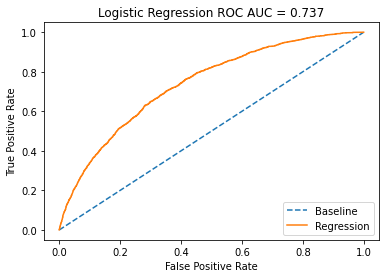

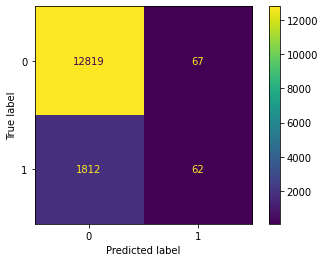

In [66]:
score(lr_op_model, X_test, y_test)

XGB

In [67]:
def objective(trial, data=X, target=y):
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in sss.split(data, target):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
    
    params = {
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 0.5, 10),
        'subsample': trial.suggest_loguniform('subsample', 0.1, 1),
        'colsample_bytree': 0,
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate' : 0.02,
        'n_estimators' : trial.suggest_int('n_estimators', 500, 2000),
        'objective' : 'binary:logistic',
        'nthread' : 1,
        'eval_metric' : 'auc'        
        }

    model = XGBClassifier(**params, seed = 42)      
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)
    
    #Смотрим финальную метрику
    roc_auc = roc_auc_score(y_test, probs[:,-1])
    
    return roc_auc

In [68]:
# Создаем задание для фреймворка
study = optuna.create_study(direction='maximize', sampler=RandomSampler())  # Максимизируем метрику
study.optimize(objective, n_trials=50)              # Количество итераций = 50

# Смотрим на финальные метрики
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_trial.value)

[I 2021-07-07 18:51:44,326] A new study created in memory with name: no-name-a66f93d5-1339-42bb-b18c-9d7b2111f16a
[I 2021-07-07 18:52:17,034] Trial 0 finished with value: 0.7332135005087715 and parameters: {'min_child_weight': 1, 'gamma': 6.247214059635519, 'subsample': 0.5025000043082669, 'max_depth': 12, 'n_estimators': 1922}. Best is trial 0 with value: 0.7332135005087715.
[I 2021-07-07 18:52:38,074] Trial 1 finished with value: 0.7336472358955664 and parameters: {'min_child_weight': 7, 'gamma': 2.0426553772019522, 'subsample': 0.14554659605497836, 'max_depth': 7, 'n_estimators': 1691}. Best is trial 1 with value: 0.7336472358955664.
[I 2021-07-07 18:53:00,349] Trial 2 finished with value: 0.7316664184787011 and parameters: {'min_child_weight': 5, 'gamma': 0.6342955143109583, 'subsample': 0.7320772643934723, 'max_depth': 7, 'n_estimators': 1583}. Best is trial 1 with value: 0.7336472358955664.
[I 2021-07-07 18:53:17,333] Trial 3 finished with value: 0.7302088456178646 and parameters

Number of finished trials: 50
Best trial: {'min_child_weight': 10, 'gamma': 1.1281650215054888, 'subsample': 0.1160637470068433, 'max_depth': 17, 'n_estimators': 1976}
Best score: 0.7344910818803294


In [69]:
# История оптимизации
plot_optimization_history(study)

In [70]:
# Значимость гиперпараметров при настройке
plot_param_importances(study)

In [71]:
# Выводим лучшие гиперпараметры
study.best_params

{'min_child_weight': 10,
 'gamma': 1.1281650215054888,
 'subsample': 0.1160637470068433,
 'max_depth': 17,
 'n_estimators': 1976}

In [72]:
params = study.best_params

In [73]:
xgb = XGBClassifier(**params, learning_rate=0.02,
        colsample_bytree = 0,
        objective='binary:logistic',
        nthread=1,
        eval_metric='auc', seed = 42 )

In [74]:
xgb_model = xgb.fit(X_train, y_train)

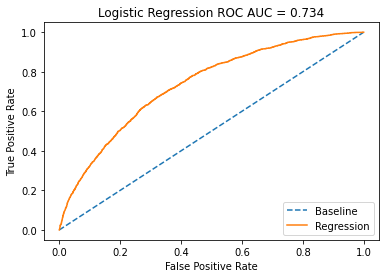

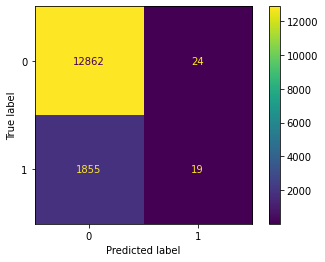

In [75]:
score(xgb_model, X_test, y_test)

In [76]:
y_pred = xgb_model.predict_proba(X1)
y_pred = y_pred[:,1]
submission_optuna = pd.DataFrame(data={'client_id':test['client_id'], 'default':y_pred})
submission_optuna.to_csv('./submission_optuna.csv', index=False)

Случайный лес

In [77]:
def objective(trial, data=X, target=y):
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in sss.split(data, target):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
    params = {'n_estimators' : trial.suggest_int('n_estimators', 10, 100), 
              'max_depth' : trial.suggest_int('max_depth', 5, 20)}
    
    # Создаем и обучаем модель с мониторингом переобучения
    model = RandomForestClassifier(**params, random_state = 42)      
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)
    
    #Смотрим финальную метрику
    roc_auc = roc_auc_score(y_test, probs[:,-1])
    
    return roc_auc

In [78]:
# Создаем задание для фреймворка
study = optuna.create_study(direction='maximize', sampler=RandomSampler())  # Максимизируем метрику
study.optimize(objective, n_trials=50)              # Количество итераций = 50

# Смотрим на финальные метрики
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_trial.value)

[I 2021-07-07 19:09:16,293] A new study created in memory with name: no-name-92d74ac0-e8ee-4e5c-9270-2f5a302d5ecb
[I 2021-07-07 19:09:18,105] Trial 0 finished with value: 0.7249380537745745 and parameters: {'n_estimators': 65, 'max_depth': 6}. Best is trial 0 with value: 0.7249380537745745.
[I 2021-07-07 19:09:21,145] Trial 1 finished with value: 0.7305624927634848 and parameters: {'n_estimators': 64, 'max_depth': 12}. Best is trial 1 with value: 0.7305624927634848.
[I 2021-07-07 19:09:23,694] Trial 2 finished with value: 0.71309095721764 and parameters: {'n_estimators': 44, 'max_depth': 18}. Best is trial 1 with value: 0.7305624927634848.
[I 2021-07-07 19:09:25,930] Trial 3 finished with value: 0.730709831937269 and parameters: {'n_estimators': 50, 'max_depth': 12}. Best is trial 3 with value: 0.730709831937269.
[I 2021-07-07 19:09:31,420] Trial 4 finished with value: 0.7217452080811768 and parameters: {'n_estimators': 95, 'max_depth': 17}. Best is trial 3 with value: 0.73070983193726

Number of finished trials: 50
Best trial: {'n_estimators': 70, 'max_depth': 9}
Best score: 0.7315576326412836


In [79]:
# История оптимизации
plot_optimization_history(study)

In [80]:
# Значимость гиперпараметров при настройке
plot_param_importances(study)

In [81]:
# Выводим лучшие гиперпараметры
study.best_params

{'n_estimators': 70, 'max_depth': 9}

In [82]:
params = study.best_params

In [83]:
rfc_op = RandomForestClassifier(**params, random_state = 42)

In [84]:
rfc_op_model = rfc_op.fit(X_train, y_train)

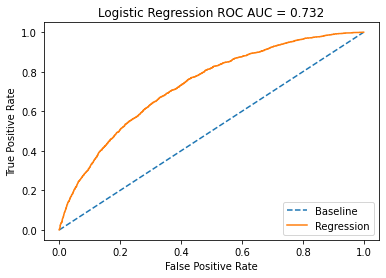

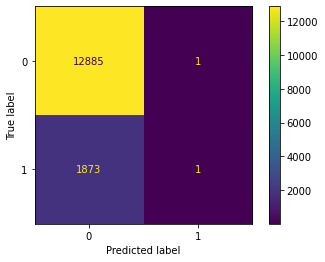

In [85]:
score(rfc_op_model, X_test, y_test)

In [86]:
y_pred = rfc_op_model.predict_proba(X1)
y_pred = y_pred[:,1]
submission_optuna_rfc = pd.DataFrame(data={'client_id':test['client_id'], 'default':y_pred})
submission_optuna_rfc.to_csv('./submission_optuna_rfc.csv', index=False)

CatBoost

In [87]:
def objective(trial, data=X, target=y):
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in sss.split(data, target):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
    params = {'depth' : trial.suggest_int('depth', 3, 10), 
              'l2_leaf_reg' : trial.suggest_int('l2_leaf_reg', 2, 10),
             'early_stopping_rounds' : trial.suggest_int('early_stopping_rounds', 5, 20)}
    
    # Создаем и обучаем модель с мониторингом переобучения
    model = CatBoostClassifier(**params, metric_period=50,
                           random_seed=42,eval_metric='AUC',
                           custom_loss=['AUC'],
                           use_best_model=True,learning_rate=0.05)      
    model.fit(X_train, y_train, eval_set=(X_test, y_test))
    probs = model.predict_proba(X_test)
    
    #Смотрим финальную метрику
    roc_auc = roc_auc_score(y_test, probs[:,-1])
    
    return roc_auc

In [88]:
# Создаем задание для фреймворка
study = optuna.create_study(direction='maximize', sampler=RandomSampler())  # Максимизируем метрику
study.optimize(objective, n_trials=50)              # Количество итераций = 50

# Смотрим на финальные метрики
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_trial.value)

[I 2021-07-07 19:12:38,274] A new study created in memory with name: no-name-3836ffff-b610-4352-9bc9-10092306e78e


0:	test: 0.7070608	best: 0.7070608 (0)	total: 98.7ms	remaining: 1m 38s
50:	test: 0.7367329	best: 0.7367329 (50)	total: 1.8s	remaining: 33.4s
100:	test: 0.7400878	best: 0.7400878 (100)	total: 3.6s	remaining: 32.1s
150:	test: 0.7404461	best: 0.7407554 (143)	total: 5.3s	remaining: 29.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.74075544
bestIteration = 143

Shrink model to first 144 iterations.


[I 2021-07-07 19:12:45,965] Trial 0 finished with value: 0.7407554399958522 and parameters: {'depth': 9, 'l2_leaf_reg': 10, 'early_stopping_rounds': 20}. Best is trial 0 with value: 0.7407554399958522.


0:	test: 0.6420797	best: 0.6420797 (0)	total: 16.5ms	remaining: 16.5s
50:	test: 0.7262351	best: 0.7262351 (50)	total: 767ms	remaining: 14.3s
100:	test: 0.7328895	best: 0.7328895 (100)	total: 1.5s	remaining: 13.4s
150:	test: 0.7359549	best: 0.7359549 (150)	total: 2.26s	remaining: 12.7s
200:	test: 0.7373095	best: 0.7373095 (200)	total: 3.02s	remaining: 12s
250:	test: 0.7383075	best: 0.7383083 (249)	total: 3.81s	remaining: 11.4s
300:	test: 0.7386596	best: 0.7387063 (295)	total: 4.62s	remaining: 10.7s
Stopped by overfitting detector  (13 iterations wait)

bestTest = 0.7387062743
bestIteration = 295

Shrink model to first 296 iterations.


[I 2021-07-07 19:12:52,776] Trial 1 finished with value: 0.7387062742635484 and parameters: {'depth': 3, 'l2_leaf_reg': 7, 'early_stopping_rounds': 13}. Best is trial 0 with value: 0.7407554399958522.


0:	test: 0.6859751	best: 0.6859751 (0)	total: 24.3ms	remaining: 24.3s
50:	test: 0.7337195	best: 0.7338232 (49)	total: 1.05s	remaining: 19.5s
100:	test: 0.7380864	best: 0.7381271 (99)	total: 2.07s	remaining: 18.4s
150:	test: 0.7399442	best: 0.7399442 (150)	total: 3.07s	remaining: 17.3s
Stopped by overfitting detector  (7 iterations wait)

bestTest = 0.7405145955
bestIteration = 178

Shrink model to first 179 iterations.


[I 2021-07-07 19:12:58,695] Trial 2 finished with value: 0.74051459552291 and parameters: {'depth': 6, 'l2_leaf_reg': 2, 'early_stopping_rounds': 7}. Best is trial 0 with value: 0.7407554399958522.


0:	test: 0.7050544	best: 0.7050544 (0)	total: 28.3ms	remaining: 28.3s
50:	test: 0.7345385	best: 0.7346091 (48)	total: 1.22s	remaining: 22.8s
100:	test: 0.7384319	best: 0.7384379 (89)	total: 2.45s	remaining: 21.8s
150:	test: 0.7393447	best: 0.7393447 (150)	total: 3.61s	remaining: 20.3s
Stopped by overfitting detector  (17 iterations wait)

bestTest = 0.740705126
bestIteration = 181

Shrink model to first 182 iterations.


[I 2021-07-07 19:13:05,991] Trial 3 finished with value: 0.7407051260284134 and parameters: {'depth': 7, 'l2_leaf_reg': 4, 'early_stopping_rounds': 17}. Best is trial 0 with value: 0.7407554399958522.


0:	test: 0.6861463	best: 0.6861463 (0)	total: 23.4ms	remaining: 23.3s
50:	test: 0.7336213	best: 0.7336213 (50)	total: 1.12s	remaining: 20.9s
100:	test: 0.7383701	best: 0.7383701 (100)	total: 2.56s	remaining: 22.8s
Stopped by overfitting detector  (8 iterations wait)

bestTest = 0.739204983
bestIteration = 116

Shrink model to first 117 iterations.


[I 2021-07-07 19:13:10,897] Trial 4 finished with value: 0.7392049829959495 and parameters: {'depth': 6, 'l2_leaf_reg': 3, 'early_stopping_rounds': 8}. Best is trial 0 with value: 0.7407554399958522.


0:	test: 0.6863334	best: 0.6863334 (0)	total: 23.2ms	remaining: 23.2s
50:	test: 0.7347460	best: 0.7347460 (50)	total: 1.06s	remaining: 19.7s
100:	test: 0.7390683	best: 0.7390683 (100)	total: 2.08s	remaining: 18.5s
150:	test: 0.7405871	best: 0.7405871 (150)	total: 3.1s	remaining: 17.5s
200:	test: 0.7417146	best: 0.7417146 (200)	total: 4.11s	remaining: 16.4s
250:	test: 0.7418710	best: 0.7419255 (235)	total: 5.1s	remaining: 15.2s
Stopped by overfitting detector  (19 iterations wait)

bestTest = 0.7422109423
bestIteration = 261

Shrink model to first 262 iterations.


[I 2021-07-07 19:13:18,502] Trial 5 finished with value: 0.7422109423230494 and parameters: {'depth': 6, 'l2_leaf_reg': 6, 'early_stopping_rounds': 19}. Best is trial 5 with value: 0.7422109423230494.


0:	test: 0.7052645	best: 0.7052645 (0)	total: 61.6ms	remaining: 1m 1s
50:	test: 0.7359257	best: 0.7359257 (50)	total: 1.51s	remaining: 28.2s
100:	test: 0.7398960	best: 0.7399100 (98)	total: 2.68s	remaining: 23.8s
150:	test: 0.7409456	best: 0.7409456 (150)	total: 3.82s	remaining: 21.5s
Stopped by overfitting detector  (9 iterations wait)

bestTest = 0.7416019156
bestIteration = 177

Shrink model to first 178 iterations.


[I 2021-07-07 19:13:24,989] Trial 6 finished with value: 0.7416019155583377 and parameters: {'depth': 7, 'l2_leaf_reg': 9, 'early_stopping_rounds': 9}. Best is trial 5 with value: 0.7422109423230494.


0:	test: 0.7071819	best: 0.7071819 (0)	total: 31.8ms	remaining: 31.7s
50:	test: 0.7351944	best: 0.7351944 (50)	total: 1.4s	remaining: 26.1s
100:	test: 0.7397957	best: 0.7397957 (100)	total: 2.78s	remaining: 24.7s
Stopped by overfitting detector  (6 iterations wait)

bestTest = 0.7403234024
bestIteration = 126

Shrink model to first 127 iterations.


[I 2021-07-07 19:13:30,506] Trial 7 finished with value: 0.7403234024466419 and parameters: {'depth': 8, 'l2_leaf_reg': 5, 'early_stopping_rounds': 6}. Best is trial 5 with value: 0.7422109423230494.


0:	test: 0.6420797	best: 0.6420797 (0)	total: 17ms	remaining: 17s
50:	test: 0.7275056	best: 0.7275056 (50)	total: 784ms	remaining: 14.6s
100:	test: 0.7330945	best: 0.7330945 (100)	total: 1.52s	remaining: 13.6s
150:	test: 0.7362421	best: 0.7362421 (150)	total: 2.29s	remaining: 12.9s
200:	test: 0.7380516	best: 0.7380516 (200)	total: 3.07s	remaining: 12.2s
250:	test: 0.7385751	best: 0.7385941 (243)	total: 3.86s	remaining: 11.5s
Stopped by overfitting detector  (8 iterations wait)

bestTest = 0.7385940513
bestIteration = 243

Shrink model to first 244 iterations.


[I 2021-07-07 19:13:36,508] Trial 8 finished with value: 0.7385940513402895 and parameters: {'depth': 3, 'l2_leaf_reg': 8, 'early_stopping_rounds': 8}. Best is trial 5 with value: 0.7422109423230494.


0:	test: 0.6420797	best: 0.6420797 (0)	total: 21.1ms	remaining: 21.1s
50:	test: 0.7263549	best: 0.7264373 (49)	total: 859ms	remaining: 16s
100:	test: 0.7329555	best: 0.7329555 (100)	total: 1.65s	remaining: 14.7s
150:	test: 0.7364265	best: 0.7364287 (149)	total: 2.41s	remaining: 13.6s
200:	test: 0.7383177	best: 0.7383282 (199)	total: 3.22s	remaining: 12.8s
250:	test: 0.7389390	best: 0.7389398 (239)	total: 4.45s	remaining: 13.3s
Stopped by overfitting detector  (16 iterations wait)

bestTest = 0.7391395127
bestIteration = 279

Shrink model to first 280 iterations.


[I 2021-07-07 19:13:44,107] Trial 9 finished with value: 0.7391395127222697 and parameters: {'depth': 3, 'l2_leaf_reg': 9, 'early_stopping_rounds': 16}. Best is trial 5 with value: 0.7422109423230494.


0:	test: 0.7066296	best: 0.7066296 (0)	total: 70.7ms	remaining: 1m 10s
50:	test: 0.7381155	best: 0.7381155 (50)	total: 2.81s	remaining: 52.4s
100:	test: 0.7414438	best: 0.7415360 (98)	total: 5.73s	remaining: 51s
150:	test: 0.7421208	best: 0.7421302 (142)	total: 8.96s	remaining: 50.4s
Stopped by overfitting detector  (19 iterations wait)

bestTest = 0.7423842874
bestIteration = 162

Shrink model to first 163 iterations.


[I 2021-07-07 19:13:56,730] Trial 10 finished with value: 0.7423842873993451 and parameters: {'depth': 10, 'l2_leaf_reg': 10, 'early_stopping_rounds': 19}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.7069777	best: 0.7069777 (0)	total: 58.4ms	remaining: 58.3s
50:	test: 0.7363747	best: 0.7363747 (50)	total: 2.73s	remaining: 50.8s
Stopped by overfitting detector  (6 iterations wait)

bestTest = 0.7409686221
bestIteration = 93

Shrink model to first 94 iterations.


[I 2021-07-07 19:14:04,303] Trial 11 finished with value: 0.7409686221393713 and parameters: {'depth': 10, 'l2_leaf_reg': 5, 'early_stopping_rounds': 6}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.6863248	best: 0.6863248 (0)	total: 23.1ms	remaining: 23.1s
50:	test: 0.7354511	best: 0.7356432 (49)	total: 1.05s	remaining: 19.6s
100:	test: 0.7387933	best: 0.7388100 (97)	total: 2.1s	remaining: 18.6s
150:	test: 0.7407370	best: 0.7407370 (150)	total: 3.14s	remaining: 17.6s
200:	test: 0.7415228	best: 0.7415228 (200)	total: 4.83s	remaining: 19.2s
Stopped by overfitting detector  (8 iterations wait)

bestTest = 0.7415591383
bestIteration = 201

Shrink model to first 202 iterations.


[I 2021-07-07 19:14:11,274] Trial 12 finished with value: 0.7415591383333464 and parameters: {'depth': 6, 'l2_leaf_reg': 7, 'early_stopping_rounds': 8}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.7067652	best: 0.7067652 (0)	total: 31ms	remaining: 31s
50:	test: 0.7343259	best: 0.7343259 (50)	total: 1.41s	remaining: 26.3s
100:	test: 0.7388125	best: 0.7389001 (98)	total: 3.14s	remaining: 28s
Stopped by overfitting detector  (9 iterations wait)

bestTest = 0.7389001176
bestIteration = 98

Shrink model to first 99 iterations.


[I 2021-07-07 19:14:16,468] Trial 13 finished with value: 0.738900117622875 and parameters: {'depth': 8, 'l2_leaf_reg': 2, 'early_stopping_rounds': 9}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.6863334	best: 0.6863334 (0)	total: 23.3ms	remaining: 23.3s
50:	test: 0.7347460	best: 0.7347460 (50)	total: 1.04s	remaining: 19.4s
100:	test: 0.7390683	best: 0.7390683 (100)	total: 2.07s	remaining: 18.5s
150:	test: 0.7405871	best: 0.7405871 (150)	total: 3.11s	remaining: 17.5s
200:	test: 0.7417146	best: 0.7417146 (200)	total: 4.13s	remaining: 16.4s
Stopped by overfitting detector  (9 iterations wait)

bestTest = 0.7417980365
bestIteration = 209

Shrink model to first 210 iterations.


[I 2021-07-07 19:14:22,829] Trial 14 finished with value: 0.7417980365046677 and parameters: {'depth': 6, 'l2_leaf_reg': 6, 'early_stopping_rounds': 9}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.6420797	best: 0.6420797 (0)	total: 16.1ms	remaining: 16s
50:	test: 0.7268614	best: 0.7269013 (48)	total: 748ms	remaining: 13.9s
100:	test: 0.7329238	best: 0.7329238 (100)	total: 1.47s	remaining: 13.1s
150:	test: 0.7359733	best: 0.7359733 (150)	total: 2.57s	remaining: 14.5s
200:	test: 0.7378178	best: 0.7378178 (200)	total: 3.34s	remaining: 13.3s
250:	test: 0.7386357	best: 0.7386357 (250)	total: 4.13s	remaining: 12.3s
Stopped by overfitting detector  (13 iterations wait)

bestTest = 0.7386357105
bestIteration = 250

Shrink model to first 251 iterations.


[I 2021-07-07 19:14:29,012] Trial 15 finished with value: 0.7386357104771156 and parameters: {'depth': 3, 'l2_leaf_reg': 5, 'early_stopping_rounds': 13}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.7071166	best: 0.7071166 (0)	total: 41.3ms	remaining: 41.3s
50:	test: 0.7360268	best: 0.7360268 (50)	total: 1.78s	remaining: 33.2s
100:	test: 0.7391993	best: 0.7391993 (100)	total: 3.58s	remaining: 31.9s
150:	test: 0.7399863	best: 0.7400710 (144)	total: 5.35s	remaining: 30.1s
Stopped by overfitting detector  (18 iterations wait)

bestTest = 0.7401339072
bestIteration = 163

Shrink model to first 164 iterations.


[I 2021-07-07 19:14:37,546] Trial 16 finished with value: 0.7401339072079582 and parameters: {'depth': 9, 'l2_leaf_reg': 2, 'early_stopping_rounds': 18}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.7072968	best: 0.7072968 (0)	total: 39.7ms	remaining: 39.7s
50:	test: 0.7360712	best: 0.7360712 (50)	total: 1.75s	remaining: 32.6s
100:	test: 0.7397454	best: 0.7397454 (100)	total: 4.24s	remaining: 37.7s
150:	test: 0.7405265	best: 0.7408928 (140)	total: 6.06s	remaining: 34.1s
Stopped by overfitting detector  (19 iterations wait)

bestTest = 0.7408927578
bestIteration = 140

Shrink model to first 141 iterations.


[I 2021-07-07 19:14:45,820] Trial 17 finished with value: 0.7408927577868215 and parameters: {'depth': 9, 'l2_leaf_reg': 3, 'early_stopping_rounds': 19}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.6420797	best: 0.6420797 (0)	total: 17.2ms	remaining: 17.2s
50:	test: 0.7262351	best: 0.7262351 (50)	total: 907ms	remaining: 16.9s
100:	test: 0.7328895	best: 0.7328895 (100)	total: 1.88s	remaining: 16.8s
150:	test: 0.7359549	best: 0.7359549 (150)	total: 2.64s	remaining: 14.8s
Stopped by overfitting detector  (6 iterations wait)

bestTest = 0.7370042128
bestIteration = 175

Shrink model to first 176 iterations.


[I 2021-07-07 19:14:50,766] Trial 18 finished with value: 0.7370042127905643 and parameters: {'depth': 3, 'l2_leaf_reg': 7, 'early_stopping_rounds': 6}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.6863248	best: 0.6863248 (0)	total: 23.4ms	remaining: 23.4s
50:	test: 0.7354511	best: 0.7356432 (49)	total: 1.05s	remaining: 19.5s
100:	test: 0.7387933	best: 0.7388100 (97)	total: 2.07s	remaining: 18.4s
150:	test: 0.7407370	best: 0.7407370 (150)	total: 3.11s	remaining: 17.5s
200:	test: 0.7415228	best: 0.7415228 (200)	total: 4.12s	remaining: 16.4s
Stopped by overfitting detector  (15 iterations wait)

bestTest = 0.7415591383
bestIteration = 201

Shrink model to first 202 iterations.


[I 2021-07-07 19:14:57,095] Trial 19 finished with value: 0.7415591383333464 and parameters: {'depth': 6, 'l2_leaf_reg': 7, 'early_stopping_rounds': 15}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.7046371	best: 0.7046371 (0)	total: 27.1ms	remaining: 27s
50:	test: 0.7355518	best: 0.7355518 (50)	total: 1.56s	remaining: 29.1s
100:	test: 0.7398081	best: 0.7398081 (100)	total: 2.75s	remaining: 24.5s
Stopped by overfitting detector  (8 iterations wait)

bestTest = 0.7405147198
bestIteration = 129

Shrink model to first 130 iterations.


[I 2021-07-07 19:15:02,587] Trial 20 finished with value: 0.7405147197549284 and parameters: {'depth': 7, 'l2_leaf_reg': 2, 'early_stopping_rounds': 8}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.6662489	best: 0.6662489 (0)	total: 19ms	remaining: 19s
50:	test: 0.7301724	best: 0.7301724 (50)	total: 850ms	remaining: 15.8s
100:	test: 0.7365354	best: 0.7366211 (99)	total: 1.68s	remaining: 14.9s
Stopped by overfitting detector  (6 iterations wait)

bestTest = 0.7366211227
bestIteration = 99

Shrink model to first 100 iterations.


[I 2021-07-07 19:15:06,228] Trial 21 finished with value: 0.7366211226565906 and parameters: {'depth': 4, 'l2_leaf_reg': 2, 'early_stopping_rounds': 6}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.7070986	best: 0.7070986 (0)	total: 30.5ms	remaining: 30.5s
50:	test: 0.7345972	best: 0.7345972 (50)	total: 1.44s	remaining: 26.7s
100:	test: 0.7386242	best: 0.7386338 (99)	total: 3.15s	remaining: 28s
150:	test: 0.7399498	best: 0.7399498 (150)	total: 4.5s	remaining: 25.3s
Stopped by overfitting detector  (11 iterations wait)

bestTest = 0.7406375852
bestIteration = 180

Shrink model to first 181 iterations.


[I 2021-07-07 19:15:13,682] Trial 22 finished with value: 0.7406375852210939 and parameters: {'depth': 8, 'l2_leaf_reg': 8, 'early_stopping_rounds': 11}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.6660280	best: 0.6660280 (0)	total: 22ms	remaining: 22s
50:	test: 0.7328425	best: 0.7329489 (49)	total: 937ms	remaining: 17.4s
100:	test: 0.7378249	best: 0.7378249 (100)	total: 1.87s	remaining: 16.6s
150:	test: 0.7392892	best: 0.7393773 (148)	total: 2.8s	remaining: 15.8s
200:	test: 0.7401421	best: 0.7401520 (199)	total: 3.73s	remaining: 14.8s
250:	test: 0.7406578	best: 0.7407231 (242)	total: 4.66s	remaining: 13.9s
Stopped by overfitting detector  (16 iterations wait)

bestTest = 0.7407231397
bestIteration = 242

Shrink model to first 243 iterations.


[I 2021-07-07 19:15:20,819] Trial 23 finished with value: 0.7407231396710767 and parameters: {'depth': 5, 'l2_leaf_reg': 2, 'early_stopping_rounds': 16}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.6662489	best: 0.6662489 (0)	total: 17.9ms	remaining: 17.9s
50:	test: 0.7304541	best: 0.7306796 (49)	total: 847ms	remaining: 15.8s
100:	test: 0.7362593	best: 0.7362593 (100)	total: 1.71s	remaining: 15.2s
150:	test: 0.7384603	best: 0.7384603 (150)	total: 2.56s	remaining: 14.4s
200:	test: 0.7399936	best: 0.7400562 (199)	total: 3.42s	remaining: 13.6s
Stopped by overfitting detector  (8 iterations wait)

bestTest = 0.7402144924
bestIteration = 213

Shrink model to first 214 iterations.


[I 2021-07-07 19:15:26,679] Trial 24 finished with value: 0.740214492377206 and parameters: {'depth': 4, 'l2_leaf_reg': 8, 'early_stopping_rounds': 8}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.7068573	best: 0.7068573 (0)	total: 59.8ms	remaining: 59.8s
50:	test: 0.7362515	best: 0.7362515 (50)	total: 2.82s	remaining: 52.5s
Stopped by overfitting detector  (13 iterations wait)

bestTest = 0.7388543588
bestIteration = 79

Shrink model to first 80 iterations.


[I 2021-07-07 19:15:34,205] Trial 25 finished with value: 0.738854358829443 and parameters: {'depth': 10, 'l2_leaf_reg': 3, 'early_stopping_rounds': 13}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.6861463	best: 0.6861463 (0)	total: 22.9ms	remaining: 22.9s
50:	test: 0.7336213	best: 0.7336213 (50)	total: 1.05s	remaining: 19.5s
100:	test: 0.7383701	best: 0.7383701 (100)	total: 2.08s	remaining: 18.6s
150:	test: 0.7398961	best: 0.7398961 (150)	total: 3.11s	remaining: 17.5s
Stopped by overfitting detector  (9 iterations wait)

bestTest = 0.7406852903
bestIteration = 189

Shrink model to first 190 iterations.


[I 2021-07-07 19:15:40,114] Trial 26 finished with value: 0.7406852903161472 and parameters: {'depth': 6, 'l2_leaf_reg': 3, 'early_stopping_rounds': 9}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.7068695	best: 0.7068695 (0)	total: 59.9ms	remaining: 59.9s
50:	test: 0.7377163	best: 0.7378972 (48)	total: 3.17s	remaining: 58.9s
100:	test: 0.7402106	best: 0.7402106 (100)	total: 6.72s	remaining: 59.9s
Stopped by overfitting detector  (7 iterations wait)

bestTest = 0.7402901083
bestIteration = 103

Shrink model to first 104 iterations.


[I 2021-07-07 19:15:49,340] Trial 27 finished with value: 0.7402901082657194 and parameters: {'depth': 10, 'l2_leaf_reg': 4, 'early_stopping_rounds': 7}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.7070986	best: 0.7070986 (0)	total: 42.2ms	remaining: 42.2s
50:	test: 0.7359958	best: 0.7359958 (50)	total: 1.82s	remaining: 33.9s
100:	test: 0.7392807	best: 0.7392807 (100)	total: 4.04s	remaining: 35.9s
150:	test: 0.7401522	best: 0.7404932 (142)	total: 5.78s	remaining: 32.5s
Stopped by overfitting detector  (19 iterations wait)

bestTest = 0.7404931862
bestIteration = 142

Shrink model to first 143 iterations.


[I 2021-07-07 19:15:57,414] Trial 28 finished with value: 0.7404931862050778 and parameters: {'depth': 9, 'l2_leaf_reg': 8, 'early_stopping_rounds': 19}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.6662489	best: 0.6662489 (0)	total: 18.2ms	remaining: 18.2s
50:	test: 0.7308447	best: 0.7309648 (48)	total: 857ms	remaining: 15.9s
100:	test: 0.7359518	best: 0.7359558 (99)	total: 1.71s	remaining: 15.2s
150:	test: 0.7383226	best: 0.7383226 (150)	total: 2.58s	remaining: 14.5s
200:	test: 0.7397044	best: 0.7397736 (196)	total: 3.44s	remaining: 13.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7403325542
bestIteration = 226

Shrink model to first 227 iterations.


[I 2021-07-07 19:16:03,520] Trial 29 finished with value: 0.7403325542053284 and parameters: {'depth': 4, 'l2_leaf_reg': 10, 'early_stopping_rounds': 20}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.6420797	best: 0.6420797 (0)	total: 33.2ms	remaining: 33.1s
50:	test: 0.7262351	best: 0.7262351 (50)	total: 1.14s	remaining: 21.3s
100:	test: 0.7328895	best: 0.7328895 (100)	total: 1.93s	remaining: 17.2s
150:	test: 0.7359549	best: 0.7359549 (150)	total: 2.72s	remaining: 15.3s
Stopped by overfitting detector  (9 iterations wait)

bestTest = 0.7370042128
bestIteration = 175

Shrink model to first 176 iterations.


[I 2021-07-07 19:16:08,697] Trial 30 finished with value: 0.7370042127905643 and parameters: {'depth': 3, 'l2_leaf_reg': 7, 'early_stopping_rounds': 9}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.7071819	best: 0.7071819 (0)	total: 30.4ms	remaining: 30.4s
50:	test: 0.7351944	best: 0.7351944 (50)	total: 1.38s	remaining: 25.7s
100:	test: 0.7397957	best: 0.7397957 (100)	total: 2.77s	remaining: 24.7s
Stopped by overfitting detector  (6 iterations wait)

bestTest = 0.7403234024
bestIteration = 126

Shrink model to first 127 iterations.


[I 2021-07-07 19:16:14,205] Trial 31 finished with value: 0.7403234024466419 and parameters: {'depth': 8, 'l2_leaf_reg': 5, 'early_stopping_rounds': 6}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.7069912	best: 0.7069912 (0)	total: 30.6ms	remaining: 30.6s
50:	test: 0.7346004	best: 0.7346004 (50)	total: 1.79s	remaining: 33.3s
100:	test: 0.7392232	best: 0.7392291 (99)	total: 3.17s	remaining: 28.2s
150:	test: 0.7409810	best: 0.7409810 (150)	total: 5.22s	remaining: 29.4s
200:	test: 0.7415722	best: 0.7417105 (190)	total: 6.57s	remaining: 26.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7417104529
bestIteration = 190

Shrink model to first 191 iterations.


[I 2021-07-07 19:16:22,897] Trial 32 finished with value: 0.7417104529317182 and parameters: {'depth': 8, 'l2_leaf_reg': 9, 'early_stopping_rounds': 20}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.7069912	best: 0.7069912 (0)	total: 31ms	remaining: 30.9s
50:	test: 0.7346004	best: 0.7346004 (50)	total: 1.4s	remaining: 26s
100:	test: 0.7392232	best: 0.7392291 (99)	total: 3.05s	remaining: 27.1s
150:	test: 0.7409810	best: 0.7409810 (150)	total: 4.46s	remaining: 25.1s
200:	test: 0.7415722	best: 0.7417105 (190)	total: 5.76s	remaining: 22.9s
Stopped by overfitting detector  (16 iterations wait)

bestTest = 0.7417104529
bestIteration = 190

Shrink model to first 191 iterations.


[I 2021-07-07 19:16:30,693] Trial 33 finished with value: 0.7417104529317182 and parameters: {'depth': 8, 'l2_leaf_reg': 9, 'early_stopping_rounds': 16}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.7067652	best: 0.7067652 (0)	total: 30.5ms	remaining: 30.5s
50:	test: 0.7343259	best: 0.7343259 (50)	total: 1.39s	remaining: 25.9s
100:	test: 0.7388125	best: 0.7389001 (98)	total: 2.77s	remaining: 24.6s
Stopped by overfitting detector  (17 iterations wait)

bestTest = 0.7389001176
bestIteration = 98

Shrink model to first 99 iterations.


[I 2021-07-07 19:16:35,790] Trial 34 finished with value: 0.738900117622875 and parameters: {'depth': 8, 'l2_leaf_reg': 2, 'early_stopping_rounds': 17}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.6420797	best: 0.6420797 (0)	total: 16ms	remaining: 15.9s
50:	test: 0.7260801	best: 0.7261524 (47)	total: 861ms	remaining: 16s
100:	test: 0.7331951	best: 0.7331951 (100)	total: 1.85s	remaining: 16.5s
150:	test: 0.7357434	best: 0.7357434 (150)	total: 2.6s	remaining: 14.6s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.7371366855
bestIteration = 178

Shrink model to first 179 iterations.


[I 2021-07-07 19:16:40,737] Trial 35 finished with value: 0.737136685532817 and parameters: {'depth': 3, 'l2_leaf_reg': 6, 'early_stopping_rounds': 5}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.7070608	best: 0.7070608 (0)	total: 40.2ms	remaining: 40.2s
50:	test: 0.7367329	best: 0.7367329 (50)	total: 1.72s	remaining: 32.1s
100:	test: 0.7400878	best: 0.7400878 (100)	total: 3.51s	remaining: 31.2s
150:	test: 0.7404461	best: 0.7407554 (143)	total: 5.22s	remaining: 29.4s
Stopped by overfitting detector  (19 iterations wait)

bestTest = 0.74075544
bestIteration = 143

Shrink model to first 144 iterations.


[I 2021-07-07 19:16:48,265] Trial 36 finished with value: 0.7407554399958522 and parameters: {'depth': 9, 'l2_leaf_reg': 10, 'early_stopping_rounds': 19}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.6662489	best: 0.6662489 (0)	total: 18.1ms	remaining: 18.1s
50:	test: 0.7304675	best: 0.7304675 (50)	total: 847ms	remaining: 15.8s
100:	test: 0.7357997	best: 0.7357997 (100)	total: 1.67s	remaining: 14.9s
150:	test: 0.7383384	best: 0.7383384 (150)	total: 3.22s	remaining: 18.1s
200:	test: 0.7400445	best: 0.7400510 (199)	total: 4.19s	remaining: 16.7s
Stopped by overfitting detector  (7 iterations wait)

bestTest = 0.7406900111
bestIteration = 236

Shrink model to first 237 iterations.


[I 2021-07-07 19:16:55,275] Trial 37 finished with value: 0.7406900111328452 and parameters: {'depth': 4, 'l2_leaf_reg': 6, 'early_stopping_rounds': 7}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.6861463	best: 0.6861463 (0)	total: 26.3ms	remaining: 26.3s
50:	test: 0.7336213	best: 0.7336213 (50)	total: 1.11s	remaining: 20.6s
100:	test: 0.7383701	best: 0.7383701 (100)	total: 2.17s	remaining: 19.4s
Stopped by overfitting detector  (8 iterations wait)

bestTest = 0.739204983
bestIteration = 116

Shrink model to first 117 iterations.


[I 2021-07-07 19:16:59,823] Trial 38 finished with value: 0.7392049829959495 and parameters: {'depth': 6, 'l2_leaf_reg': 3, 'early_stopping_rounds': 8}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.7069777	best: 0.7069777 (0)	total: 59.1ms	remaining: 59.1s
50:	test: 0.7363747	best: 0.7363747 (50)	total: 2.82s	remaining: 52.5s
100:	test: 0.7407813	best: 0.7409686 (93)	total: 5.7s	remaining: 50.8s
Stopped by overfitting detector  (8 iterations wait)

bestTest = 0.7409686221
bestIteration = 93

Shrink model to first 94 iterations.


[I 2021-07-07 19:17:07,677] Trial 39 finished with value: 0.7409686221393713 and parameters: {'depth': 10, 'l2_leaf_reg': 5, 'early_stopping_rounds': 8}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.6859751	best: 0.6859751 (0)	total: 22.8ms	remaining: 22.7s
50:	test: 0.7337195	best: 0.7338232 (49)	total: 1.04s	remaining: 19.4s
100:	test: 0.7380864	best: 0.7381271 (99)	total: 2.44s	remaining: 21.7s
150:	test: 0.7399442	best: 0.7399442 (150)	total: 3.49s	remaining: 19.6s
200:	test: 0.7407184	best: 0.7407387 (198)	total: 4.49s	remaining: 17.8s
Stopped by overfitting detector  (13 iterations wait)

bestTest = 0.7410048979
bestIteration = 214

Shrink model to first 215 iterations.


[I 2021-07-07 19:17:14,570] Trial 40 finished with value: 0.7410048978887348 and parameters: {'depth': 6, 'l2_leaf_reg': 2, 'early_stopping_rounds': 13}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.6662489	best: 0.6662489 (0)	total: 18.8ms	remaining: 18.8s
50:	test: 0.7301724	best: 0.7301724 (50)	total: 862ms	remaining: 16s
100:	test: 0.7365354	best: 0.7366211 (99)	total: 1.66s	remaining: 14.8s
150:	test: 0.7385043	best: 0.7385043 (150)	total: 2.5s	remaining: 14.1s
200:	test: 0.7398523	best: 0.7398523 (200)	total: 3.33s	remaining: 13.2s
Stopped by overfitting detector  (9 iterations wait)

bestTest = 0.7405100818
bestIteration = 238

Shrink model to first 239 iterations.


[I 2021-07-07 19:17:20,553] Trial 41 finished with value: 0.7405100817595759 and parameters: {'depth': 4, 'l2_leaf_reg': 2, 'early_stopping_rounds': 9}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.6662489	best: 0.6662489 (0)	total: 56.6ms	remaining: 56.5s
50:	test: 0.7304541	best: 0.7306796 (49)	total: 1.13s	remaining: 21s
100:	test: 0.7362593	best: 0.7362593 (100)	total: 1.96s	remaining: 17.4s
150:	test: 0.7384603	best: 0.7384603 (150)	total: 3.1s	remaining: 17.5s
200:	test: 0.7399936	best: 0.7400562 (199)	total: 4.38s	remaining: 17.4s
250:	test: 0.7405000	best: 0.7405018 (248)	total: 5.22s	remaining: 15.6s
300:	test: 0.7405459	best: 0.7405932 (289)	total: 6.08s	remaining: 14.1s
Stopped by overfitting detector  (18 iterations wait)

bestTest = 0.7405931516
bestIteration = 289

Shrink model to first 290 iterations.


[I 2021-07-07 19:17:28,720] Trial 42 finished with value: 0.7405931515691913 and parameters: {'depth': 4, 'l2_leaf_reg': 8, 'early_stopping_rounds': 18}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.6661338	best: 0.6661338 (0)	total: 22.6ms	remaining: 22.6s
50:	test: 0.7318717	best: 0.7318717 (50)	total: 964ms	remaining: 17.9s
100:	test: 0.7372174	best: 0.7372174 (100)	total: 1.95s	remaining: 17.3s
150:	test: 0.7392152	best: 0.7392152 (150)	total: 3.02s	remaining: 17s
200:	test: 0.7400398	best: 0.7400398 (200)	total: 4.15s	remaining: 16.5s
250:	test: 0.7407150	best: 0.7407995 (240)	total: 5.08s	remaining: 15.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7407995424
bestIteration = 240

Shrink model to first 241 iterations.


[I 2021-07-07 19:17:35,886] Trial 43 finished with value: 0.7407995423623729 and parameters: {'depth': 5, 'l2_leaf_reg': 3, 'early_stopping_rounds': 20}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.7052416	best: 0.7052416 (0)	total: 26.9ms	remaining: 26.9s
50:	test: 0.7350114	best: 0.7350114 (50)	total: 1.24s	remaining: 23.1s
100:	test: 0.7384492	best: 0.7384492 (100)	total: 2.41s	remaining: 21.4s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.7386901241
bestIteration = 106

Shrink model to first 107 iterations.


[I 2021-07-07 19:17:40,545] Trial 44 finished with value: 0.7386901241011607 and parameters: {'depth': 7, 'l2_leaf_reg': 8, 'early_stopping_rounds': 10}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.7068977	best: 0.7068977 (0)	total: 59ms	remaining: 59s
50:	test: 0.7361527	best: 0.7361527 (50)	total: 3.15s	remaining: 58.6s
100:	test: 0.7397202	best: 0.7397737 (98)	total: 6.07s	remaining: 54s
Stopped by overfitting detector  (19 iterations wait)

bestTest = 0.7403074593
bestIteration = 122

Shrink model to first 123 iterations.


[I 2021-07-07 19:17:50,847] Trial 45 finished with value: 0.740307459337618 and parameters: {'depth': 10, 'l2_leaf_reg': 8, 'early_stopping_rounds': 19}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.7069912	best: 0.7069912 (0)	total: 30.7ms	remaining: 30.6s
50:	test: 0.7346004	best: 0.7346004 (50)	total: 1.4s	remaining: 26.1s
100:	test: 0.7392232	best: 0.7392291 (99)	total: 2.99s	remaining: 26.6s
150:	test: 0.7409810	best: 0.7409810 (150)	total: 4.47s	remaining: 25.2s
200:	test: 0.7415722	best: 0.7417105 (190)	total: 6.49s	remaining: 25.8s
Stopped by overfitting detector  (11 iterations wait)

bestTest = 0.7417104529
bestIteration = 190

Shrink model to first 191 iterations.


[I 2021-07-07 19:17:59,216] Trial 46 finished with value: 0.7417104529317182 and parameters: {'depth': 8, 'l2_leaf_reg': 9, 'early_stopping_rounds': 11}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.6663766	best: 0.6663766 (0)	total: 21.3ms	remaining: 21.3s
50:	test: 0.7319352	best: 0.7319352 (50)	total: 957ms	remaining: 17.8s
100:	test: 0.7371285	best: 0.7371285 (100)	total: 1.93s	remaining: 17.1s
150:	test: 0.7389344	best: 0.7389344 (150)	total: 2.88s	remaining: 16.2s
200:	test: 0.7398350	best: 0.7398350 (200)	total: 3.84s	remaining: 15.3s
250:	test: 0.7404161	best: 0.7404278 (246)	total: 4.77s	remaining: 14.2s
Stopped by overfitting detector  (19 iterations wait)

bestTest = 0.7404878442
bestIteration = 256

Shrink model to first 257 iterations.


[I 2021-07-07 19:18:06,486] Trial 47 finished with value: 0.7404878442282882 and parameters: {'depth': 5, 'l2_leaf_reg': 8, 'early_stopping_rounds': 19}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.7046371	best: 0.7046371 (0)	total: 27.1ms	remaining: 27.1s
50:	test: 0.7355518	best: 0.7355518 (50)	total: 1.2s	remaining: 22.3s
100:	test: 0.7398081	best: 0.7398081 (100)	total: 2.41s	remaining: 21.5s
Stopped by overfitting detector  (14 iterations wait)

bestTest = 0.7405147198
bestIteration = 129

Shrink model to first 130 iterations.


[I 2021-07-07 19:18:11,781] Trial 48 finished with value: 0.7405147197549284 and parameters: {'depth': 7, 'l2_leaf_reg': 2, 'early_stopping_rounds': 14}. Best is trial 10 with value: 0.7423842873993451.


0:	test: 0.6863896	best: 0.6863896 (0)	total: 23.6ms	remaining: 23.5s
50:	test: 0.7353303	best: 0.7353303 (50)	total: 1.06s	remaining: 19.7s
100:	test: 0.7390907	best: 0.7390907 (100)	total: 2.08s	remaining: 18.6s
150:	test: 0.7405832	best: 0.7405832 (150)	total: 3.11s	remaining: 17.5s
Stopped by overfitting detector  (6 iterations wait)

bestTest = 0.7409938826
bestIteration = 167

Shrink model to first 168 iterations.


[I 2021-07-07 19:18:17,297] Trial 49 finished with value: 0.740993882649773 and parameters: {'depth': 6, 'l2_leaf_reg': 9, 'early_stopping_rounds': 6}. Best is trial 10 with value: 0.7423842873993451.


Number of finished trials: 50
Best trial: {'depth': 10, 'l2_leaf_reg': 10, 'early_stopping_rounds': 19}
Best score: 0.7423842873993451


In [89]:
# История оптимизации
plot_optimization_history(study)

In [90]:
# Значимость гиперпараметров при настройке
plot_param_importances(study)

In [91]:
# Выводим лучшие гиперпараметры
study.best_params

{'depth': 10, 'l2_leaf_reg': 10, 'early_stopping_rounds': 19}

In [92]:
params = study.best_params

In [93]:
cat_op = CatBoostClassifier(**params, metric_period=50,
                           random_seed=42,eval_metric='AUC',
                           custom_loss=['AUC'],
                           use_best_model=True,learning_rate=0.05)   

In [94]:
cat_op_model = cat_op.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	test: 0.7066296	best: 0.7066296 (0)	total: 60.8ms	remaining: 1m
50:	test: 0.7381155	best: 0.7381155 (50)	total: 3.13s	remaining: 58.3s
100:	test: 0.7414438	best: 0.7415360 (98)	total: 6.06s	remaining: 54s
150:	test: 0.7421208	best: 0.7421302 (142)	total: 8.92s	remaining: 50.2s
Stopped by overfitting detector  (19 iterations wait)

bestTest = 0.7423842874
bestIteration = 162

Shrink model to first 163 iterations.


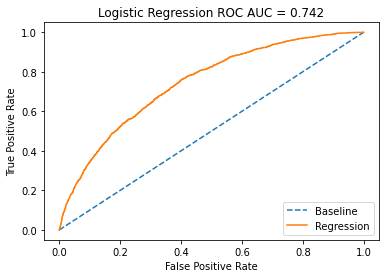

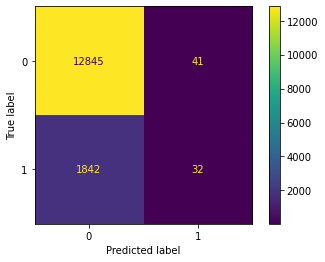

In [95]:
score(cat_op_model, X_test, y_test)

In [96]:
y_pred = cat_op_model.predict_proba(X1)
y_pred = y_pred[:,1]
submission_optuna_cat = pd.DataFrame(data={'client_id':test['client_id'], 'default':y_pred})
submission_optuna_cat.to_csv('./submission_optuna_cat.csv', index=False)

## SKLEARN

# Линейная регрессия

In [97]:
lr = LogisticRegression(random_state = 42)

In [98]:
model = lr
# Зададим ограничения для параметра регуляризации
C = np.logspace(2, 4, 20)
max_iter = [x for x in range(100,1000,200)]

# Создадим гиперпараметры
params = dict(C=C, max_iter = max_iter)

#Создаем сетку поиска с использованием 5-кратной перекрестной проверки
lr_grid = GridSearchCV(model, params, cv=5, verbose=0, scoring='roc_auc', n_jobs=-1)


In [99]:
lr_model_grid = lr_grid.fit(X_train, y_train)

In [100]:
# View best hyperparameters
print('Лучшее Penalty:', lr_model_grid.best_estimator_.get_params()['penalty'])
print('Лучшее C:', lr_model_grid.best_estimator_.get_params()['C'])
print('Лучшее solver:', lr_model_grid.best_estimator_.get_params()['solver'])
print('Лучшее max_iter:', lr_model_grid.best_estimator_.get_params()['max_iter'])

Лучшее Penalty: l2
Лучшее C: 10000.0
Лучшее solver: lbfgs
Лучшее max_iter: 100


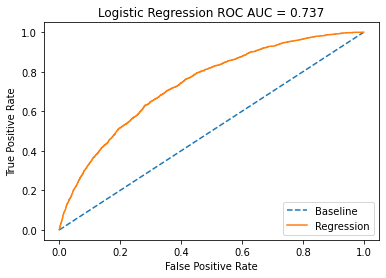

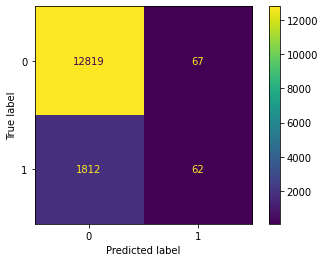

In [101]:
score(lr_model_grid, X_test, y_test)

In [102]:

lr_rnd = RandomizedSearchCV(model, param_distributions=params, n_iter=5, scoring='roc_auc', 
                                   n_jobs=-1, cv=5, verbose=3, random_state=42)

In [103]:
lr_model_rnd = lr_rnd.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [104]:
# View best hyperparameters
print('Лучшее Penalty:', lr_model_rnd.best_estimator_.get_params()['penalty'])
print('Лучшее C:', lr_model_rnd.best_estimator_.get_params()['C'])
print('Лучшее solver:', lr_model_rnd.best_estimator_.get_params()['solver'])
print('Лучшее max_iter:', lr_model_rnd.best_estimator_.get_params()['max_iter'])

Лучшее Penalty: l2
Лучшее C: 4832.930238571752
Лучшее solver: lbfgs
Лучшее max_iter: 700


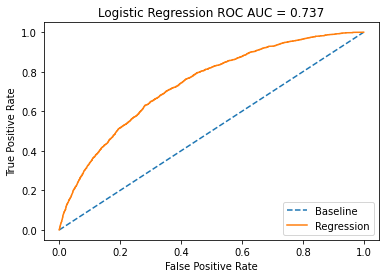

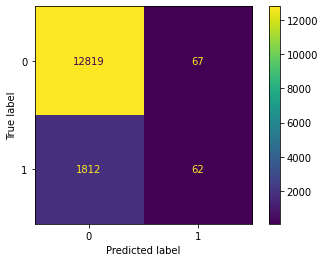

In [105]:
score(lr_model_rnd, X_test, y_test)

# XGB

In [106]:
params = {
        'min_child_weight': [x for x in range(1, 10)],
        'gamma': [x for x in np.arange(0.5, 10, 0.1)],
        'subsample': [x for x in np.arange(0.1, 1, 0.1)],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [x for x in range(3, 8)]
        }


xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    nthread=1, eval_metric='auc', seed = 42)

model = xgb

Следующий кусок кода лучше не запускать

In [ ]:
xgb_grid = GridSearchCV(model, params, cv=5, verbose=0)

In [ ]:
xgb_model_grid = xgb_grid.fit(X_train, y_train)

In [ ]:
# View best hyperparameters
print('Лучшее min_child_weight:', xgb_model_grid.best_estimator_.get_params()['min_child_weight'])
print('Лучшее gamma:', xgb_model_grid.best_estimator_.get_params()['gamma'])
print('Лучшее subsample:', xgb_model_grid.best_estimator_.get_params()['subsample'])
print('Лучшее colsample_bytree:', xgb_model_grid.best_estimator_.get_params()['colsample_bytree'])
print('Лучшее max_depth:', xgb_model_grid.best_estimator_.get_params()['max_depth'])

In [ ]:
score(xgb_model_grid, X_test, y_test)

Он будет выполняться несколько дней

In [107]:
xgb_rnd = RandomizedSearchCV(model, param_distributions=params, n_iter=5, scoring='roc_auc', 
                                   n_jobs=-1, cv=5, verbose=3, random_state=42)

In [108]:
xgb_model_rnd = xgb_rnd.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [109]:
# View best hyperparameters
print('Лучшее min_child_weight:', xgb_model_rnd.best_estimator_.get_params()['min_child_weight'])
print('Лучшее gamma:', xgb_model_rnd.best_estimator_.get_params()['gamma'])
print('Лучшее subsample:', xgb_model_rnd.best_estimator_.get_params()['subsample'])
print('Лучшее colsample_bytree:', xgb_model_rnd.best_estimator_.get_params()['colsample_bytree'])
print('Лучшее max_depth:', xgb_model_rnd.best_estimator_.get_params()['max_depth'])

Лучшее min_child_weight: 6
Лучшее gamma: 0.7
Лучшее subsample: 0.6
Лучшее colsample_bytree: 0.6
Лучшее max_depth: 3


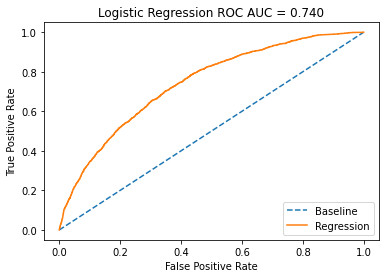

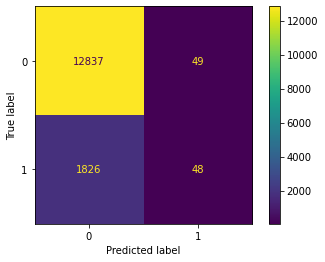

In [110]:
score(xgb_model_rnd, X_test, y_test)

# Случайный лес

In [111]:
params = {'n_estimators' : [10, 20], 'max_depth' : [9, 10, 11]}

In [112]:
rfc = RandomForestClassifier(random_state = 42)
model = rfc
rfc_grid = GridSearchCV(model, params, cv=5, verbose=0, scoring='roc_auc', n_jobs=-1)

In [113]:
rfc_model_grid = rfc_grid.fit(X_train, y_train)

In [114]:
print('Лучшее n_estimators:', rfc_model_grid.best_estimator_.get_params()['n_estimators'])
print('Лучшее max_depth:', rfc_model_grid.best_estimator_.get_params()['max_depth'])

Лучшее n_estimators: 20
Лучшее max_depth: 9


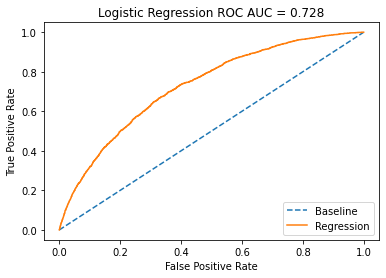

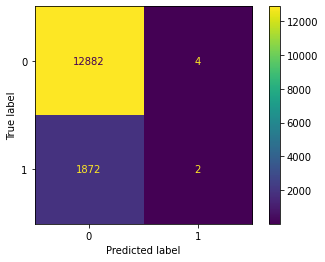

In [115]:
score(rfc_model_grid, X_test, y_test)

In [116]:
params = {'n_estimators' : [x for x in range(10, 20, 10)], 'max_depth' : [x for x in range(5, 10)]}

In [117]:
rfc_rnd = RandomizedSearchCV(model, param_distributions=params, n_iter=5, scoring='roc_auc', 
                                   n_jobs=-1, cv=5, verbose=3, random_state=42)

In [118]:
rfc_model_rnd = rfc_rnd.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [119]:
print('Лучшее n_estimators:', rfc_model_rnd.best_estimator_.get_params()['n_estimators'])
print('Лучшее max_depth:', rfc_model_rnd.best_estimator_.get_params()['max_depth'])

Лучшее n_estimators: 10
Лучшее max_depth: 7


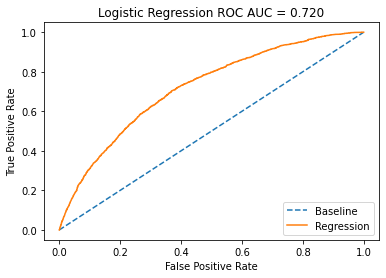

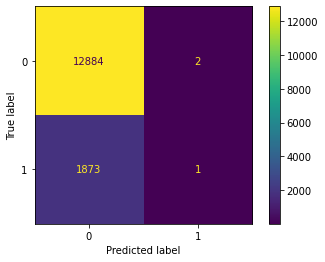

In [120]:
score(rfc_model_rnd, X_test, y_test)

# CatBoost

In [121]:
cat = CatBoostClassifier(  iterations=1000,
                           metric_period=150,
                           random_seed=42,
                           depth=6,
                           l2_leaf_reg=5,
                           eval_metric='AUC',
                           custom_loss=['AUC', 'Accuracy'],
                           use_best_model=True,
                           early_stopping_rounds=10,
                           learning_rate=0.05,
                           boosting_type='Ordered',
                           bootstrap_type='MVS')

In [122]:
params = {'leaf_estimation_method' : ['Newton', 'Gradient']}
model = cat
cat_grid = GridSearchCV(model, params, cv=5, verbose=0, scoring='roc_auc', n_jobs=-1)

In [123]:
cat_model_grid = cat_grid.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	test: 0.6530835	best: 0.6530835 (0)	total: 87ms	remaining: 1m 26s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.7279272832
bestIteration = 27

Shrink model to first 28 iterations.


In [124]:
print('Лучшее leaf_estimation_method:', cat_model_grid.best_estimator_.get_params()['leaf_estimation_method'])

Лучшее leaf_estimation_method: Newton


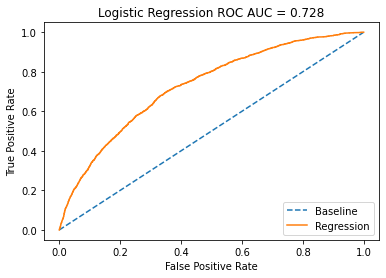

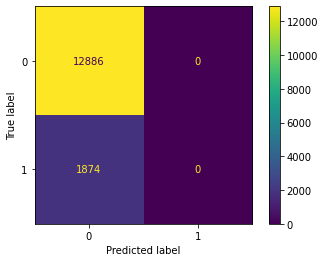

In [125]:
score(cat_model_grid, X_test, y_test)

Модель вообще никому не отказала в кредите!!!!

In [126]:
cat_rnd = RandomizedSearchCV(model, param_distributions=params, n_iter=5, scoring='roc_auc', 
                                   n_jobs=-1, cv=5, verbose=3, random_state=42)

In [127]:
cat_model_rnd = cat_rnd.fit(X_train, y_train, eval_set=(X_test, y_test))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


0:	test: 0.6530835	best: 0.6530835 (0)	total: 80.6ms	remaining: 1m 20s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.7279272832
bestIteration = 27

Shrink model to first 28 iterations.


In [128]:
print('Лучшее leaf_estimation_method:', cat_model_rnd.best_estimator_.get_params()['leaf_estimation_method'])

Лучшее leaf_estimation_method: Newton


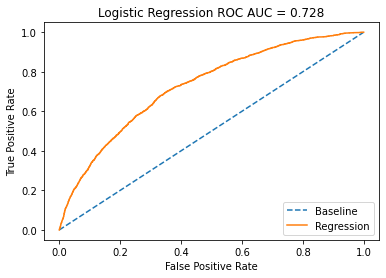

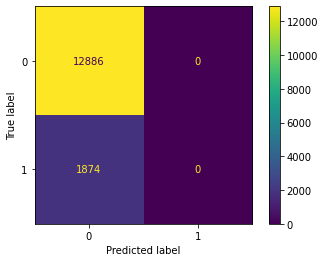

In [129]:
score(cat_model_rnd, X_test, y_test)

# Линейная регрессия

# grid

In [130]:
y_pred_lr_model_grid = lr_model_grid.predict_proba(X1)
y_pred_lr_model_grid = y_pred_lr_model_grid[:,1]

In [131]:
submission_lr_model_grid_cv = pd.DataFrame(data={'client_id':test['client_id'], 'default':y_pred_lr_model_grid})

In [ ]:
submission_lr_model_grid_cv.default.value_counts()

In [ ]:
submission_lr_model_grid_cv

In [132]:
submission_lr_model_grid_cv.to_csv('./submission_lr_model_grid_cv.csv', index=False)

# random

In [133]:
y_pred_lr_model_rnd = lr_model_rnd.predict_proba(X1)
y_pred_lr_model_rnd = y_pred_lr_model_rnd[:,1]

In [134]:
submission_lr_model_rnd_cv = pd.DataFrame(data={'client_id':test['client_id'], 'default':y_pred_lr_model_rnd})

In [ ]:
submission_lr_model_rnd_cv.default.value_counts()

In [ ]:
submission_lr_model_rnd_cv

In [135]:
submission_lr_model_rnd_cv.to_csv('./submission_lr_model_rnd_cv.csv', index=False)

# XGB

# grid

In [ ]:
y_pred_xgb_model_grid = xgb_model_grid.predict_proba(X1)
y_pred_xgb_model_grid = y_pred_xgb_model_grid[:,1]

In [ ]:
submission_xgb_model_grid_cv = pd.DataFrame(data={'client_id':test['client_id'], 'default':y_pred_xgb_model_grid})

In [ ]:
submission_xgb_model_grid_cv.default.value_counts()

In [ ]:
submission_xgb_model_grid_cv

In [ ]:
submission_xgb_model_grid_cv.to_csv('./submission_xgb_model_grid_cv.csv', index=False)

# random

In [136]:
y_pred_xgb_model_rnd = xgb_model_rnd.predict_proba(X1)
y_pred_xgb_model_rnd = y_pred_xgb_model_rnd[:,1]

In [137]:
submission_xgb_model_rnd_cv = pd.DataFrame(data={'client_id':test['client_id'], 'default':y_pred_xgb_model_rnd})

In [ ]:
submission_xgb_model_rnd_cv.default.value_counts()

In [ ]:
submission_xgb_model_rnd_cv

In [138]:
submission_xgb_model_rnd_cv.to_csv('./submission_xgb_model_rnd_cv.csv', index=False)

# Случайный лес

# grid

In [139]:
y_pred_rfc_model_grid = rfc_model_grid.predict_proba(X1)
y_pred_rfc_model_grid = y_pred_rfc_model_grid[:,1]

In [140]:
submission_rfc_model_grid_cv = pd.DataFrame(data={'client_id':test['client_id'], 'default':y_pred_rfc_model_grid})

In [ ]:
submission_rfc_model_grid_cv.default.value_counts()

In [ ]:
submission_rfc_model_grid_cv

In [141]:
submission_rfc_model_grid_cv.to_csv('./submission_rfc_model_grid_cv.csv', index=False)

# random

In [142]:
y_pred_rfc_model_rnd = rfc_model_rnd.predict_proba(X1)
y_pred_rfc_model_rnd = y_pred_rfc_model_rnd[:,1]

In [143]:
submission_rfc_model_rnd_cv = pd.DataFrame(data={'client_id':test['client_id'], 'default':y_pred_rfc_model_rnd})

In [ ]:
submission_rfc_model_rnd_cv.default.value_counts()

In [ ]:
submission_rfc_model_rnd_cv

In [144]:
submission_rfc_model_rnd_cv.to_csv('./submission_rfc_model_rnd_cv.csv', index=False)

# CatBoost

# grid

In [145]:
y_pred_cat_model_grid = cat_model_grid.predict_proba(X1)
y_pred_cat_model_grid = y_pred_cat_model_grid[:,1]

In [146]:
submission_cat_model_grid_cv = pd.DataFrame(data={'client_id':test['client_id'], 'default':y_pred_cat_model_grid})

In [ ]:
submission_cat_model_grid_cv.default.value_counts()

In [ ]:
submission_cat_model_grid_cv

In [147]:
submission_cat_model_grid_cv.to_csv('./submission_cat_model_grid_cv.csv', index=False)

# random

In [148]:
y_pred_cat_model_rnd = cat_model_rnd.predict_proba(X1)
y_pred_cat_model_rnd = y_pred_cat_model_rnd[:,1]

In [149]:
submission_cat_model_rnd_cv = pd.DataFrame(data={'client_id':test['client_id'], 'default':y_pred_cat_model_rnd})

In [ ]:
submission_cat_model_rnd_cv.default.value_counts()

In [ ]:
submission_cat_model_rnd_cv

In [150]:
submission_cat_model_rnd_cv.to_csv('./submission_cat_model_rnd_cv.csv', index=False)

## Выводы

Все модели плохо обучились. Хоть метрика и неплохая, но конфьюжн матрица говорит о том, что модели практически не отказывают в выдаче кредита. Это происходит из-за разбаланса в классах не только целевой переменной, но и в других параметрах. Даже если продублировать признак default, модели переобучаются. Подбор гиперпараметров очень ресурсозатратный, поэтому не удалось оптимизировать модель.